## KMeans Clustering

In [3]:
! pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 8]

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.preprocessing import StandardScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv',usecols=['Date','Close'])
df = df['Close']

In [6]:
df1 = df.values.reshape(-1, 1)

import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

time_step = 100
X, y = create_dataset(df1, time_step)

X = X.reshape(X.shape[0],X.shape[1] , 1)

In [7]:
X.shape

(1916, 100, 1)

In [8]:
seed = 0
np.random.seed(seed)
X = TimeSeriesScalerMeanVariance().fit_transform(X)
sz = X.shape[1]

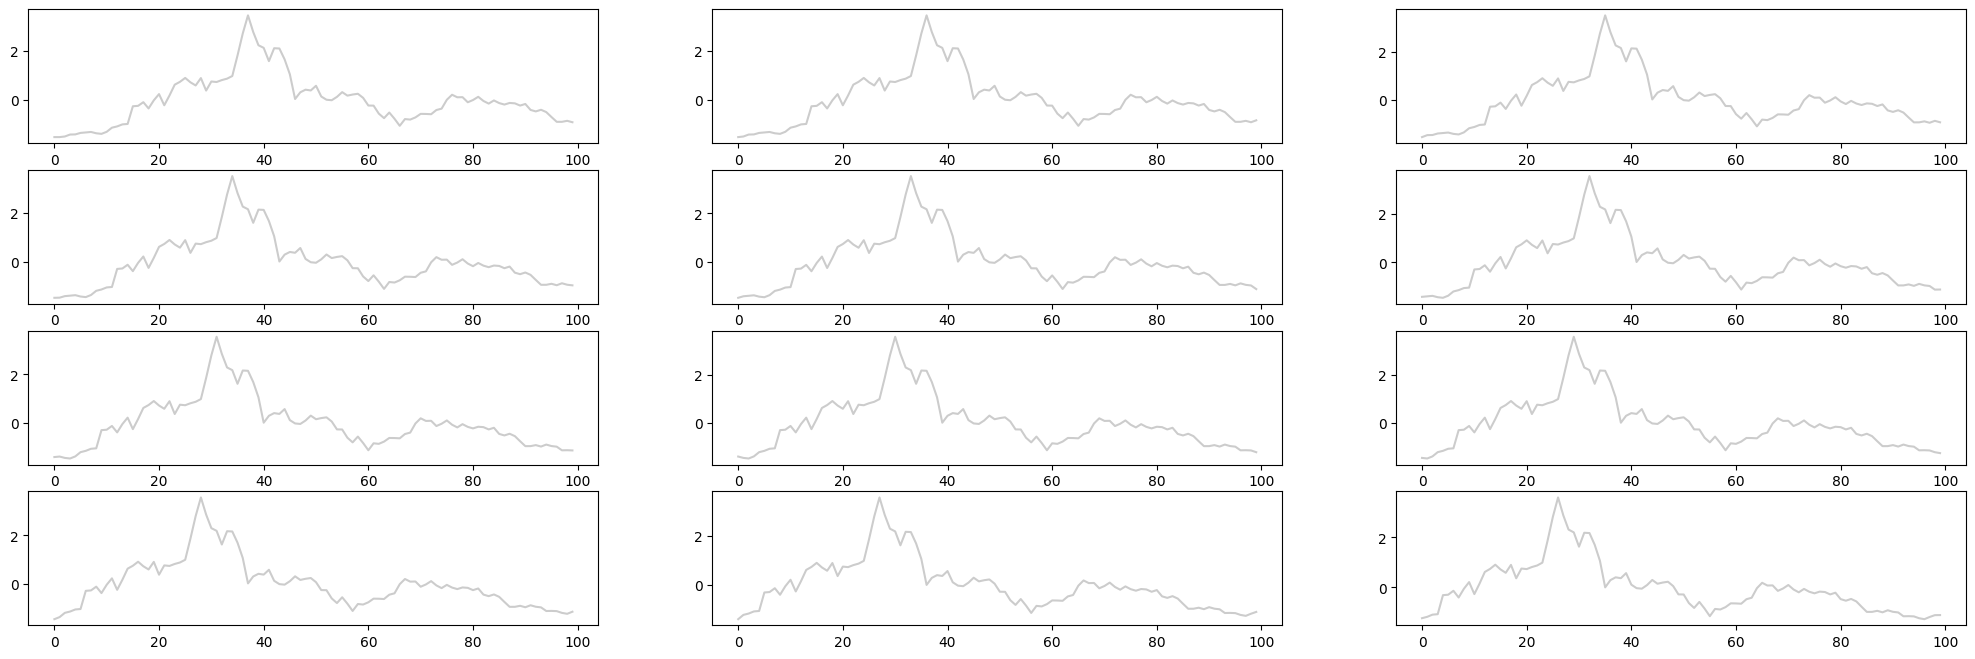

In [9]:
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(X[yi].ravel(), "k-", alpha=.2)

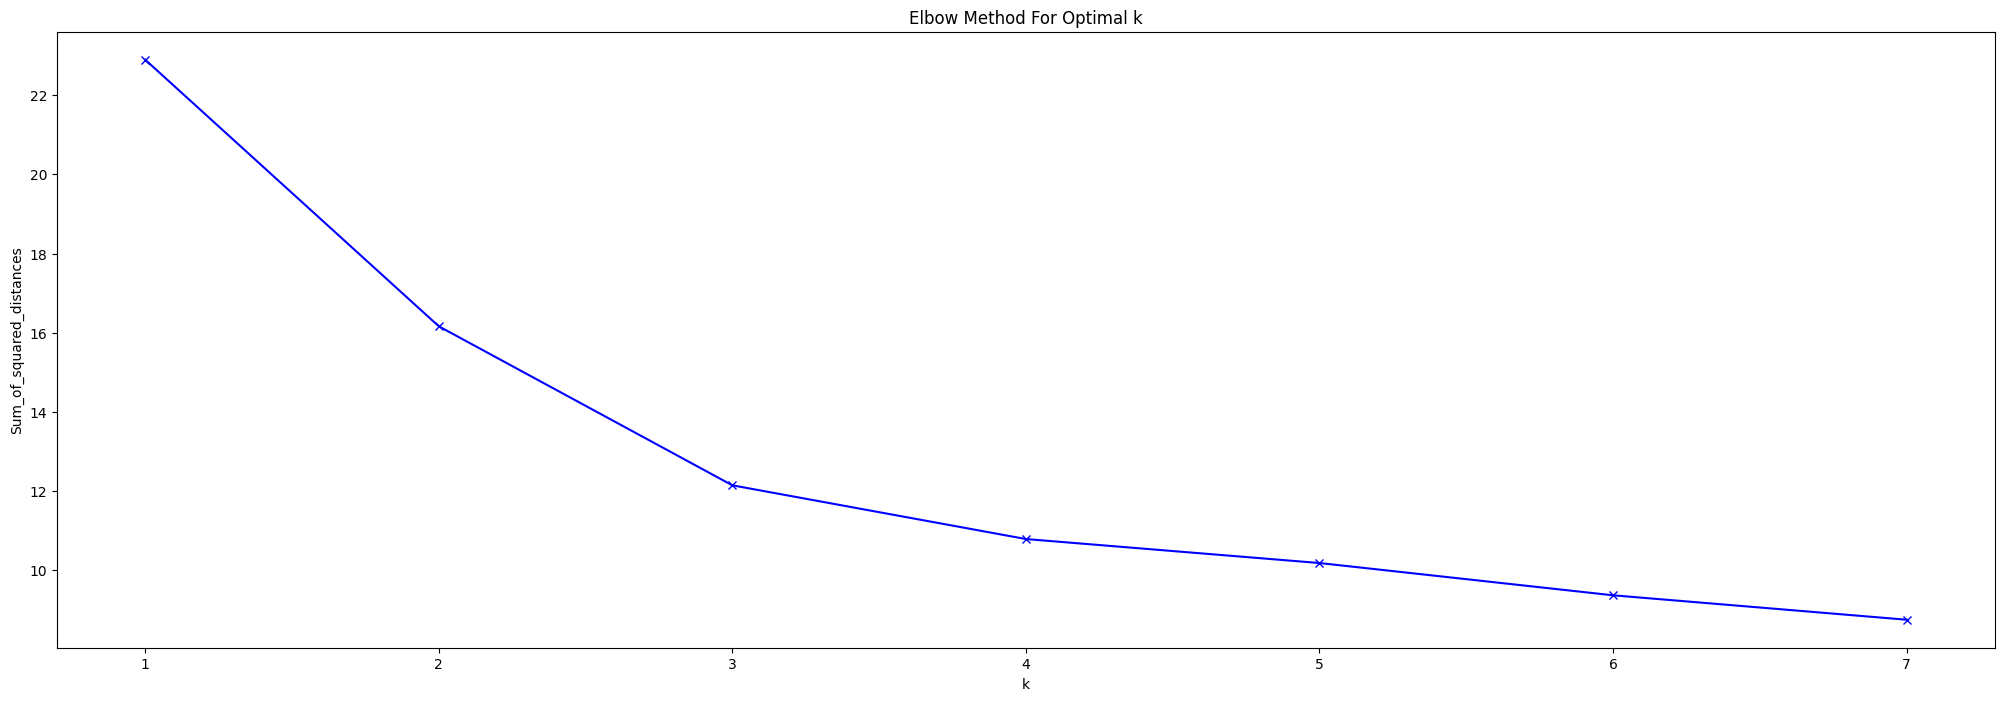

In [10]:
# Using sum of squared distances to decide cluster number
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)

    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

-----Euclidean k-means-----
Euclidean silhoutte: 0.26


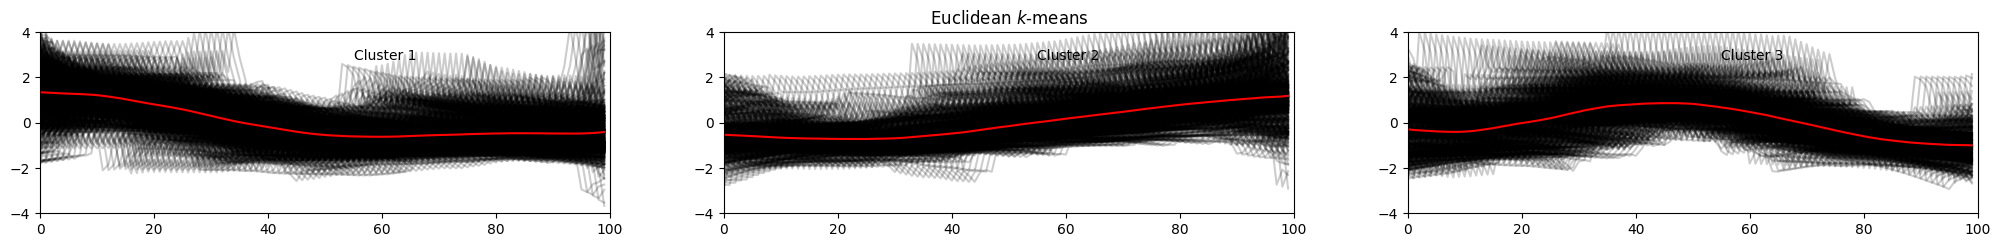

In [11]:
# Euclidean k-means
print("-----Euclidean k-means-----")
n_clusters=3
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_km = km.fit_predict(X)

print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X, y_km, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X[y_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

In [12]:
y_km.shape

(1916,)

DBA k-means
DBA silhoutte: 0.33


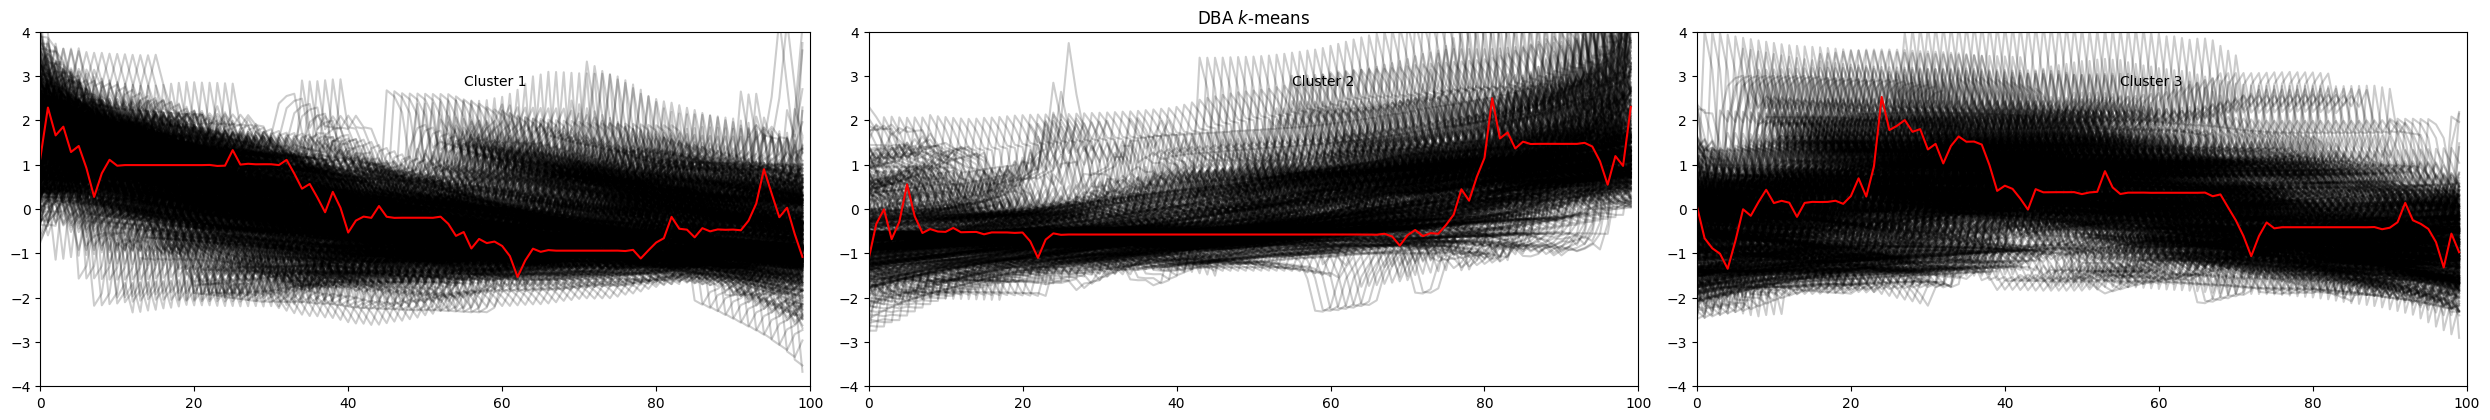

In [13]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_dba_km = dba_km.fit_predict(X)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X, y_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(2, n_clusters, yi+1)
    for xx in X[y_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

plt.tight_layout()
plt.show()

In [14]:
y_dba_km.shape

(1916,)

In [15]:
cluster_labels = dba_km.labels_

cluster_0 = X[cluster_labels == 0]
cluster_1 = X[cluster_labels == 1]
cluster_2 = X[cluster_labels == 2]

In [16]:
print(cluster_0.shape)
print(cluster_1.shape)
print(cluster_2.shape)

(736, 100, 1)
(523, 100, 1)
(657, 100, 1)


# RNN

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

## 7:2:1

### Cluster 0

In [18]:
# Number of samples in cluster_0
num_samples = cluster_0.shape[0]

# Create an array of random indices for the samples
indices = np.random.permutation(num_samples)

# Calculate the number of samples for each set
num_train = int(0.7 * num_samples)
num_test = int(0.2 * num_samples)

# Split the data into train, test, validate sets
train_indices = indices[:num_train]
test_indices = indices[num_train:num_train+num_test]
val_indices = indices[num_train+num_test:]

# Create sublists to store the samples and corresponding labels
X_train = []
y_train = []
X_test = []
ytest = []
X_val = []
yval = []

# Create X_train and y_train
for i in train_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_train.append(sample)
    y_train.append(label)

# Create X_test and ytest
for i in test_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_test.append(sample)
    ytest.append(label)

# Create X_val and yval
for i in val_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_val.append(sample)
    yval.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1)
X_test = np.array(X_test)
ytest = np.array(ytest).reshape(-1)
X_val = np.array(X_val)
yval = np.array(yval).reshape(-1)

# Check the shape of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("ytest shape:", ytest.shape)
print("X_val shape:", X_val.shape)
print("yval shape:", yval.shape)

X_train shape: (515, 100, 1)
y_train shape: (515,)
X_test shape: (147, 100, 1)
ytest shape: (147,)
X_val shape: (74, 100, 1)
yval shape: (74,)


In [19]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 2s 90ms/step - loss: 1.3034 - val_loss: 0.4602
Epoch 2/100
9/9 [==============================] - 0s 25ms/step - loss: 0.3800 - val_loss: 0.2579
Epoch 3/100
9/9 [==============================] - 0s 28ms/step - loss: 0.2451 - val_loss: 0.1750
Epoch 4/100
9/9 [==============================] - 0s 30ms/step - loss: 0.1790 - val_loss: 0.1267
Epoch 5/100
9/9 [==============================] - 0s 43ms/step - loss: 0.1408 - val_loss: 0.1053
Epoch 6/100
9/9 [==============================] - 0s 49ms/step - loss: 0.1159 - val_loss: 0.0883
Epoch 7/100
9/9 [==============================] - 0s 53ms/step - loss: 0.1012 - val_loss: 0.0810
Epoch 8/100
9/9 [==============================] - 0s 51ms/step - loss: 0.0910 - val_loss: 0.0708
Epoch 9/100
9/9 [==============================] - 0s 51ms/step - loss: 0.0802 - val_loss: 0.0638
Epoch 10/100
9/9 [==============================] - 0s 50ms/step - loss: 0.0732 - val_loss: 0.0578
Epoch 11/100
9/9 [=

In [21]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 12ms/step


In [22]:
print('---------VALIDATE----------')

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAE: 0.7906256589220347
RMSE: 1.0051436072642899
--------------------------
---------TEST----------
MAE: 0.9433896551929682
RMSE: 1.2145708369042696
-------------------


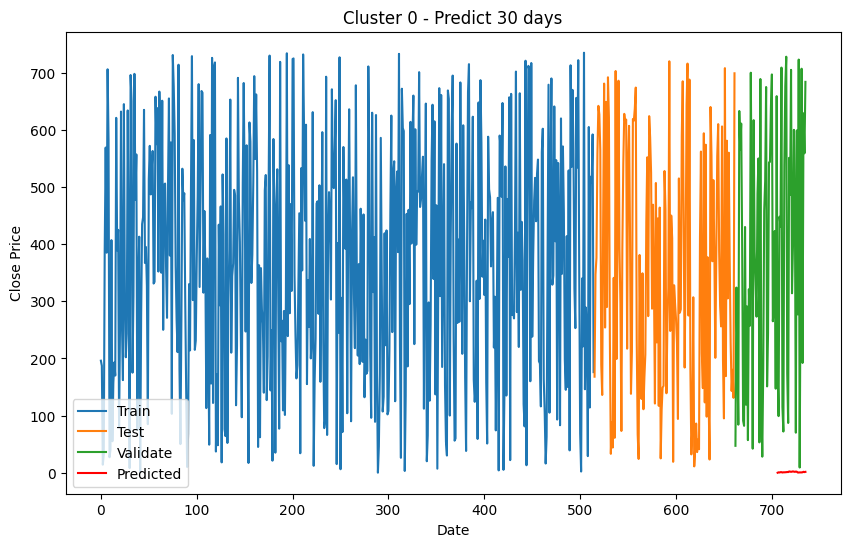

In [23]:
predicted_prices = cluster_0[-30:]
predicted_prices_reshaped = predicted_prices.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices, label='Train')
plt.plot(range(num_train, num_train+len(test_indices)), test_indices, label='Test')
plt.plot(range(num_train+num_test, num_train+num_test+len(val_indices)), val_indices, label='Validate')

plt.plot(range(len(cluster_0) - 30, len(cluster_0)), predicted_prices_reshaped[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 0 - Predict 30 days')
plt.legend()
plt.show()

In [24]:
predicted_prices_reshaped

array([[[-0.08213673],
        [ 0.57954072],
        [ 0.35103014],
        ...,
        [-0.50581802],
        [-0.28721086],
        [-0.2629377 ]],

       [[ 0.57958054],
        [ 0.35107076],
        [ 0.8447811 ],
        ...,
        [-0.287168  ],
        [-0.26289491],
        [-0.08628025]],

       [[ 0.36073132],
        [ 0.8549976 ],
        [ 0.8970366 ],
        ...,
        [-0.25392572],
        [-0.07711217],
        [-0.33702455]],

       ...,

       [[ 1.58930649],
        [ 0.94837577],
        [ 1.35916318],
        ...,
        [-0.88975175],
        [-1.21104748],
        [-1.18992011]],

       [[ 0.982038  ],
        [ 1.39536524],
        [ 1.57165956],
        ...,
        [-1.1907366 ],
        [-1.1694786 ],
        [-1.152927  ]],

       [[ 1.41554215],
        [ 1.59201189],
        [ 1.29394408],
        ...,
        [-1.15185383],
        [-1.13528577],
        [-0.87704134]]])

### Cluster 1

In [25]:
# Number of samples in cluster_1
num_samples1 = cluster_1.shape[0]

# Create an array of random indices for the samples
indices1 = np.random.permutation(num_samples1)

# Calculate the number of samples for each set
num_train1 = int(0.7 * num_samples1)
num_test1 = int(0.2 * num_samples1)

# Split the data into train, test, validate sets
train_indices1 = indices1[:num_train1]
test_indices1 = indices1[num_train1:num_train1+num_test1]
val_indices1 = indices1[num_train1+num_test1:]

# Create sublists to store the samples and corresponding labels
X_train1 = []
y_train1= []
X_test1 = []
ytest1 = []
X_val1 = []
yval1 = []

# Create X_train1 and y_train1
for i in train_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_train1.append(sample)
    y_train1.append(label)

# Create X_test1 and ytest1
for i in test_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_test1.append(sample)
    ytest1.append(label)

# Create X_val1 and yval1
for i in val_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_val1.append(sample)
    yval1.append(label)

# Convert lists to numpy arrays
X_train1 = np.array(X_train1)
y_train1= np.array(y_train1).reshape(-1)
X_test1 = np.array(X_test1)
ytest1 = np.array(ytest1).reshape(-1)
X_val1 = np.array(X_val1)
yval1 = np.array(yval1).reshape(-1)

# Check the shape of the datasets
print("X_train1 shape:", X_train1.shape)
print("y_train1shape:", y_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("ytest1 shape:", ytest1.shape)
print("X_val1 shape:", X_val1.shape)
print("yval1 shape:", yval1.shape)

X_train1 shape: (366, 100, 1)
y_train1shape: (366,)
X_test1 shape: (104, 100, 1)
ytest1 shape: (104,)
X_val1 shape: (53, 100, 1)
yval1 shape: (53,)


In [26]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(50, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [27]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
6/6 [==============================] - 2s 119ms/step - loss: 3.3806 - val_loss: 1.3027
Epoch 2/100
6/6 [==============================] - 0s 28ms/step - loss: 1.5547 - val_loss: 0.7538
Epoch 3/100
6/6 [==============================] - 0s 32ms/step - loss: 1.1133 - val_loss: 0.6867
Epoch 4/100
6/6 [==============================] - 0s 31ms/step - loss: 0.9143 - val_loss: 0.4725
Epoch 5/100
6/6 [==============================] - 0s 31ms/step - loss: 0.7101 - val_loss: 0.3573
Epoch 6/100
6/6 [==============================] - 0s 31ms/step - loss: 0.6186 - val_loss: 0.2967
Epoch 7/100
6/6 [==============================] - 0s 32ms/step - loss: 0.5329 - val_loss: 0.2427
Epoch 8/100
6/6 [==============================] - 0s 30ms/step - loss: 0.4649 - val_loss: 0.2123
Epoch 9/100
6/6 [==============================] - 0s 31ms/step - loss: 0.4024 - val_loss: 0.1763
Epoch 10/100
6/6 [==============================] - 0s 37ms/step - loss: 0.3638 - val_loss: 0.1550
Epoch 11/100
6/6 [

In [28]:
train_predict1=model.predict(X_train1)
y_pred1=model.predict(X_test1)
y_pred_val1=model.predict(X_val1)

2/2 [==============================] - 0s 10ms/step


In [29]:
print('---------VALIDATE----------')

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAE: 1.206815360549217
RMSE: 1.6219639935526957
--------------------------
---------TEST----------
MAE: 1.0622822042475557
RMSE: 1.4700227096024154
-------------------


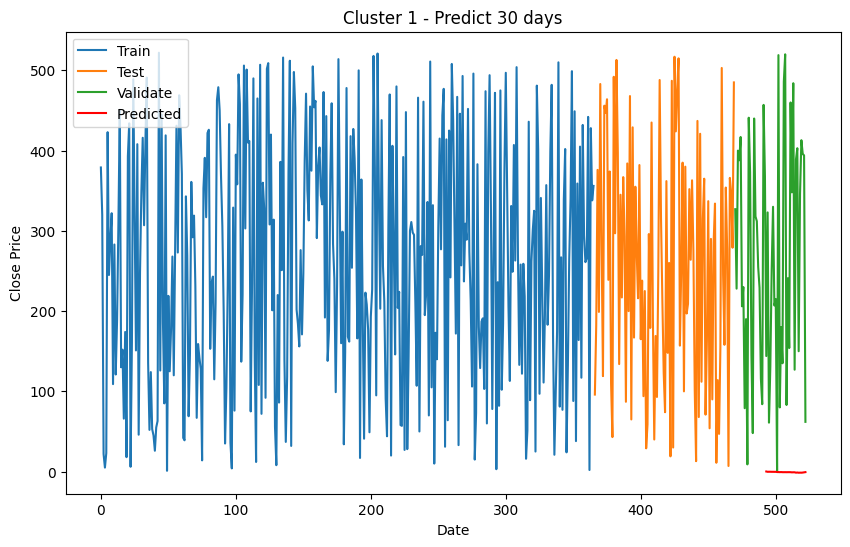

In [30]:
predicted_prices1 = cluster_1[-30:]
predicted_prices_reshaped1 = predicted_prices1.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices1, label='Train')
plt.plot(range(num_train1, num_train1+len(test_indices1)), test_indices1, label='Test')
plt.plot(range(num_train1+num_test1, num_train1+num_test1+len(val_indices1)), val_indices1, label='Validate')
plt.plot(range(len(cluster_1) - 30, len(cluster_1)), predicted_prices_reshaped1[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 1 - Predict 30 days')
plt.legend()
plt.show()

### Cluster 2

In [31]:
# Number of samples in cluster_2
num_samples2 = cluster_2.shape[0]

# Create an array of random indices for the samples
indices2 = np.random.permutation(num_samples2)

# Calculate the number of samples for each set
num_train2 = int(0.7 * num_samples2)
num_test2 = int(0.2 * num_samples2)

# Split the data into train, test, validate sets
train_indices2 = indices2[:num_train2]
test_indices2 = indices2[num_train2:num_train2+num_test2]
val_indices2 = indices2[num_train2+num_test2:]

# Create sublists to store the samples and corresponding labels
X_train2 = []
y_train2= []
X_test2 = []
ytest2 = []
X_val2 = []
yval2 = []

# Create X_train2 and y_train
for i in train_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_train2.append(sample)
    y_train2.append(label)

# Create X_test2 and ytest2
for i in test_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_test2.append(sample)
    ytest2.append(label)

# Create X_val2 and yval2
for i in val_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_val2.append(sample)
    yval2.append(label)

# Convert lists to numpy arrays
X_train2 = np.array(X_train2)
y_train2= np.array(y_train2).reshape(-1)
X_test2 = np.array(X_test2)
ytest2 = np.array(ytest2).reshape(-1)
X_val2 = np.array(X_val2)
yval2 = np.array(yval2).reshape(-1)

# Check the shape of the datasets
print("X_train2 shape:", X_train2.shape)
print("y_train2shape:", y_train2.shape)
print("X_test2 shape:", X_test2.shape)
print("ytest2 shape:", ytest2.shape)
print("X_val2 shape:", X_val2.shape)
print("yval2 shape:", yval2.shape)

X_train2 shape: (459, 100, 1)
y_train2shape: (459,)
X_test2 shape: (131, 100, 1)
ytest2 shape: (131,)
X_val2 shape: (67, 100, 1)
yval2 shape: (67,)


In [32]:
#Define LSTM Model
model2 = Sequential()
model2.add(SimpleRNN(50, input_shape=(time_step, 1)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',optimizer='adam')

In [33]:
model2.fit(X_train2,y_train2,validation_data=(X_test2,ytest2),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
8/8 [==============================] - 2s 62ms/step - loss: 0.2648 - val_loss: 0.0784
Epoch 2/100
8/8 [==============================] - 0s 33ms/step - loss: 0.0572 - val_loss: 0.0472
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0347 - val_loss: 0.0247
Epoch 4/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0247 - val_loss: 0.0158
Epoch 5/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0189 - val_loss: 0.0120
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0150 - val_loss: 0.0118
Epoch 7/100
8/8 [==============================] - 0s 44ms/step - loss: 0.0128 - val_loss: 0.0102
Epoch 8/100
8/8 [==============================] - 0s 52ms/step - loss: 0.0111 - val_loss: 0.0083
Epoch 9/100
8/8 [==============================] - 0s 49ms/step - loss: 0.0095 - val_loss: 0.0068
Epoch 10/100
8/8 [==============================] - 0s 50ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 11/100
8/8 [=

In [34]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

3/3 [==============================] - 0s 9ms/step


In [35]:
print('---------VALIDATE----------')

valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAE: 0.7278619116613139
RMSE: 0.9122451510836713
--------------------------
---------TEST----------
MAE: 0.7258418086931898
RMSE: 0.8946513340197604
-------------------


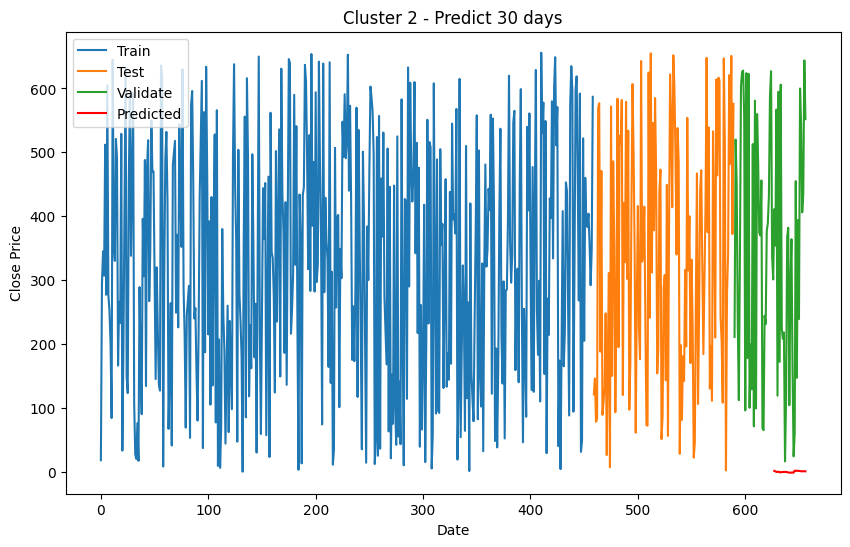

In [36]:
predicted_prices2 = cluster_2[-30:]
predicted_prices_reshaped2 = predicted_prices2.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices2, label='Train')
plt.plot(range(num_train2, num_train2+len(test_indices2)), test_indices2, label='Test')
plt.plot(range(num_train2+num_test2, num_train2+num_test2+len(val_indices2)), val_indices2, label='Validate')
plt.plot(range(len(cluster_2) - 30, len(cluster_2)), predicted_prices_reshaped2[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 2 - Predict 30 days')
plt.legend()
plt.show()

###MAE - RMSE

In [37]:
print('---------VALIDATE----------')
rnn_val_mae =  (valid_mae + valid_mae1 + valid_mae2) / 3
rnn_val_rmse = (valid_rmse + valid_rmse1 + valid_rmse2) / 3
print("Validate mae:",rnn_val_mae)
print("Validate rmse:",rnn_val_rmse)

print('---------------------------')
print('---------TEST--------------')
rnn_test_mae =  (test_mae + test_mae1 + test_mae2) / 3
rnn_test_rmse = (test_rmse + test_rmse1 + test_rmse2) / 3
print("Test mae:",rnn_test_mae)
print("Test rmse:",rnn_test_rmse)
print('---------------------------')

---------VALIDATE----------
Validate mae: 0.9084343103775218
Validate rmse: 1.1797842506335523
---------------------------
---------TEST--------------
Test mae: 0.9105045560445713
Test rmse: 1.1930816268421485
---------------------------


## 5:3:2

### Cluster 0

In [38]:
# Number of samples in cluster_0
num_samples = cluster_0.shape[0]

# Create an array of random indices for the samples
indices = np.random.permutation(num_samples)

# Calculate the number of samples for each set
num_train = int(0.5 * num_samples)
num_test = int(0.3 * num_samples)

# Split the data into train, test, validate sets
train_indices = indices[:num_train]
test_indices = indices[num_train:num_train+num_test]
val_indices = indices[num_train+num_test:]

# Create sublists to store the samples and corresponding labels
X_train = []
y_train = []
X_test = []
ytest = []
X_val = []
yval = []

# Create X_train and y_train
for i in train_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_train.append(sample)
    y_train.append(label)

# Create X_test and ytest
for i in test_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_test.append(sample)
    ytest.append(label)

# Create X_val and yval
for i in val_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_val.append(sample)
    yval.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1)
X_test = np.array(X_test)
ytest = np.array(ytest).reshape(-1)
X_val = np.array(X_val)
yval = np.array(yval).reshape(-1)

# Check the shape of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("ytest shape:", ytest.shape)
print("X_val shape:", X_val.shape)
print("yval shape:", yval.shape)

X_train shape: (368, 100, 1)
y_train shape: (368,)
X_test shape: (220, 100, 1)
ytest shape: (220,)
X_val shape: (148, 100, 1)
yval shape: (148,)


In [39]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [40]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
6/6 [==============================] - 2s 90ms/step - loss: 1.2884 - val_loss: 0.5749
Epoch 2/100
6/6 [==============================] - 0s 54ms/step - loss: 0.5549 - val_loss: 0.3224
Epoch 3/100
6/6 [==============================] - 0s 61ms/step - loss: 0.3268 - val_loss: 0.2458
Epoch 4/100
6/6 [==============================] - 0s 60ms/step - loss: 0.2514 - val_loss: 0.2099
Epoch 5/100
6/6 [==============================] - 0s 69ms/step - loss: 0.2054 - val_loss: 0.1867
Epoch 6/100
6/6 [==============================] - 0s 63ms/step - loss: 0.1809 - val_loss: 0.1503
Epoch 7/100
6/6 [==============================] - 0s 61ms/step - loss: 0.1532 - val_loss: 0.1294
Epoch 8/100
6/6 [==============================] - 0s 64ms/step - loss: 0.1346 - val_loss: 0.1136
Epoch 9/100
6/6 [==============================] - 0s 65ms/step - loss: 0.1196 - val_loss: 0.1013
Epoch 10/100
6/6 [==============================] - 0s 57ms/step - loss: 0.1081 - val_loss: 0.0914
Epoch 11/100
6/6 [=

In [41]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 8ms/step


In [42]:
print('---------VALIDATE----------')

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAE: 0.9194070793707155
RMSE: 1.1845178504550318
--------------------------
---------TEST----------
MAE: 0.837523657127125
RMSE: 1.0841728494222147
-------------------


### Cluster 1

In [43]:
# Number of samples in cluster_1
num_samples1 = cluster_1.shape[0]

# Create an array of random indices for the samples
indices1 = np.random.permutation(num_samples1)

# Calculate the number of samples for each set
num_train1 = int(0.5 * num_samples1)
num_test1 = int(0.3 * num_samples1)

# Split the data into train, test, validate sets
train_indices1 = indices1[:num_train1]
test_indices1 = indices1[num_train1:num_train1+num_test1]
val_indices1 = indices1[num_train1+num_test1:]

# Create sublists to store the samples and corresponding labels
X_train1 = []
y_train1= []
X_test1 = []
ytest1 = []
X_val1 = []
yval1 = []

# Create X_train1 and y_train
for i in train_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_train1.append(sample)
    y_train1.append(label)

# Create X_test1 and ytest1
for i in test_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_test1.append(sample)
    ytest1.append(label)

# Create X_val1 and yval1
for i in val_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_val1.append(sample)
    yval1.append(label)

# Convert lists to numpy arrays
X_train1 = np.array(X_train1)
y_train1= np.array(y_train1).reshape(-1)
X_test1 = np.array(X_test1)
ytest1 = np.array(ytest1).reshape(-1)
X_val1 = np.array(X_val1)
yval1 = np.array(yval1).reshape(-1)

# Check the shape of the datasets
print("X_train1 shape:", X_train1.shape)
print("y_train1shape:", y_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("ytest1 shape:", ytest1.shape)
print("X_val1 shape:", X_val1.shape)
print("yval1 shape:", yval1.shape)

X_train1 shape: (261, 100, 1)
y_train1shape: (261,)
X_test1 shape: (156, 100, 1)
ytest1 shape: (156,)
X_val1 shape: (106, 100, 1)
yval1 shape: (106,)


In [44]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(50, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [45]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
5/5 [==============================] - 2s 135ms/step - loss: 3.0073 - val_loss: 1.1525
Epoch 2/100
5/5 [==============================] - 0s 61ms/step - loss: 1.7407 - val_loss: 0.8559
Epoch 3/100
5/5 [==============================] - 0s 60ms/step - loss: 1.2989 - val_loss: 0.5420
Epoch 4/100
5/5 [==============================] - 0s 63ms/step - loss: 0.8611 - val_loss: 0.3301
Epoch 5/100
5/5 [==============================] - 0s 64ms/step - loss: 0.6409 - val_loss: 0.2629
Epoch 6/100
5/5 [==============================] - 0s 56ms/step - loss: 0.5270 - val_loss: 0.2336
Epoch 7/100
5/5 [==============================] - 0s 59ms/step - loss: 0.4415 - val_loss: 0.2496
Epoch 8/100
5/5 [==============================] - 0s 55ms/step - loss: 0.4065 - val_loss: 0.2238
Epoch 9/100
5/5 [==============================] - 0s 64ms/step - loss: 0.3600 - val_loss: 0.1944
Epoch 10/100
5/5 [==============================] - 0s 67ms/step - loss: 0.3349 - val_loss: 0.1778
Epoch 11/100
5/5 [

In [46]:
train_predict1=model.predict(X_train1)
y_pred1=model.predict(X_test1)
y_pred_val1=model.predict(X_val1)

4/4 [==============================] - 0s 8ms/step


In [47]:
print('---------VALIDATE----------')

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAE: 1.3147832867343467
RMSE: 1.8360199058826678
--------------------------
---------TEST----------
MAE: 0.9932214327091682
RMSE: 1.3398137693395609
-------------------


### Cluster 2

In [48]:
# Number of samples in cluster_2
num_samples2 = cluster_2.shape[0]

# Create an array of random indices for the samples
indices2 = np.random.permutation(num_samples2)

# Calculate the number of samples for each set
num_train2 = int(0.5 * num_samples2)
num_test2 = int(0.3 * num_samples2)

# Split the data into train, test, validate sets
train_indices2 = indices2[:num_train2]
test_indices2 = indices2[num_train2:num_train2+num_test2]
val_indices2 = indices2[num_train2+num_test2:]

# Create sublists to store the samples and corresponding labels
X_train2 = []
y_train2= []
X_test2 = []
ytest2 = []
X_val2 = []
yval2 = []

# Create X_train2 and y_train
for i in train_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_train2.append(sample)
    y_train2.append(label)

# Create X_test2 and ytest2
for i in test_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_test2.append(sample)
    ytest2.append(label)

# Create X_val2 and yval2
for i in val_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_val2.append(sample)
    yval2.append(label)

# Convert lists to numpy arrays
X_train2 = np.array(X_train2)
y_train2= np.array(y_train2).reshape(-1)
X_test2 = np.array(X_test2)
ytest2 = np.array(ytest2).reshape(-1)
X_val2 = np.array(X_val2)
yval2 = np.array(yval2).reshape(-1)

# Check the shape of the datasets
print("X_train2 shape:", X_train2.shape)
print("y_train2shape:", y_train2.shape)
print("X_test2 shape:", X_test2.shape)
print("ytest2 shape:", ytest2.shape)
print("X_val2 shape:", X_val2.shape)
print("yval2 shape:", yval2.shape)

X_train2 shape: (328, 100, 1)
y_train2shape: (328,)
X_test2 shape: (197, 100, 1)
ytest2 shape: (197,)
X_val2 shape: (132, 100, 1)
yval2 shape: (132,)


In [49]:
#Define LSTM Model
model2 = Sequential()
model2.add(SimpleRNN(50, input_shape=(time_step, 1)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',optimizer='adam')

In [50]:
model2.fit(X_train2,y_train2,validation_data=(X_test2,ytest2),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
6/6 [==============================] - 2s 86ms/step - loss: 1.0727 - val_loss: 0.3607
Epoch 2/100
6/6 [==============================] - 0s 40ms/step - loss: 0.3480 - val_loss: 0.2572
Epoch 3/100
6/6 [==============================] - 0s 41ms/step - loss: 0.2232 - val_loss: 0.1522
Epoch 4/100
6/6 [==============================] - 0s 37ms/step - loss: 0.1377 - val_loss: 0.1193
Epoch 5/100
6/6 [==============================] - 0s 36ms/step - loss: 0.1024 - val_loss: 0.0904
Epoch 6/100
6/6 [==============================] - 0s 35ms/step - loss: 0.0742 - val_loss: 0.0658
Epoch 7/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0557 - val_loss: 0.0467
Epoch 8/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0427 - val_loss: 0.0357
Epoch 9/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0344 - val_loss: 0.0310
Epoch 10/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0294 - val_loss: 0.0228
Epoch 11/100
6/6 [=

In [51]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

5/5 [==============================] - 0s 8ms/step


In [52]:
print('---------VALIDATE----------')
valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAE: 0.7983366395049742
RMSE: 1.0088107177902415
--------------------------
---------TEST----------
MAE: 0.7585609366869561
RMSE: 0.9384339306567104
-------------------


###MAE - RMSE

In [53]:
print('---------VALIDATE----------')
rnn_val_mae =  (valid_mae + valid_mae1 + valid_mae2) / 3
rnn_val_rmse = (valid_rmse + valid_rmse1 + valid_rmse2) / 3
print("Validate mae:",rnn_val_mae)
print("Validate rmse:",rnn_val_rmse)

print('---------------------------')
print('---------TEST--------------')
rnn_test_mae =  (test_mae + test_mae1 + test_mae2) / 3
rnn_test_rmse = (test_rmse + test_rmse1 + test_rmse2) / 3
print("Test mae:",rnn_test_mae)
print("Test rmse:",rnn_test_rmse)
print('---------------------------')

---------VALIDATE----------
Validate mae: 1.0108423352033455
Validate rmse: 1.343116158042647
---------------------------
---------TEST--------------
Test mae: 0.863102008841083
Test rmse: 1.120806849806162
---------------------------


## 6:2:2

### Cluster 0

In [54]:
# Number of samples in cluster_0
num_samples = cluster_0.shape[0]

# Create an array of random indices for the samples
indices = np.random.permutation(num_samples)

# Calculate the number of samples for each set
num_train = int(0.6 * num_samples)
num_test = int(0.2 * num_samples)

# Split the data into train, test, validate sets
train_indices = indices[:num_train]
test_indices = indices[num_train:num_train+num_test]
val_indices = indices[num_train+num_test:]

# Create sublists to store the samples and corresponding labels
X_train = []
y_train = []
X_test = []
ytest = []
X_val = []
yval = []

# Create X_train and y_train
for i in train_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_train.append(sample)
    y_train.append(label)

# Create X_test and ytest
for i in test_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_test.append(sample)
    ytest.append(label)

# Create X_val and yval
for i in val_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_val.append(sample)
    yval.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1)
X_test = np.array(X_test)
ytest = np.array(ytest).reshape(-1)
X_val = np.array(X_val)
yval = np.array(yval).reshape(-1)

# Check the shape of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("ytest shape:", ytest.shape)
print("X_val shape:", X_val.shape)
print("yval shape:", yval.shape)

X_train shape: (441, 100, 1)
y_train shape: (441,)
X_test shape: (147, 100, 1)
ytest shape: (147,)
X_val shape: (148, 100, 1)
yval shape: (148,)


In [55]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [56]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 [==============================] - 2s 77ms/step - loss: 0.2835 - val_loss: 0.1440
Epoch 2/100
7/7 [==============================] - 0s 36ms/step - loss: 0.1657 - val_loss: 0.1093
Epoch 3/100
7/7 [==============================] - 0s 32ms/step - loss: 0.1226 - val_loss: 0.0899
Epoch 4/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0983 - val_loss: 0.0622
Epoch 5/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0808 - val_loss: 0.0489
Epoch 6/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0701 - val_loss: 0.0430
Epoch 7/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0592 - val_loss: 0.0348
Epoch 8/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0510 - val_loss: 0.0309
Epoch 9/100
7/7 [==============================] - 0s 39ms/step - loss: 0.0440 - val_loss: 0.0275
Epoch 10/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0380 - val_loss: 0.0244
Epoch 11/100
7/7 [=

In [57]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 10ms/step


In [58]:
print('---------VALIDATE----------')

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAE: 0.8460162464630637
RMSE: 1.0748005304460888
--------------------------
---------TEST----------
MAE: 0.9864608539542149
RMSE: 1.2508463331533244
-------------------


### Cluster 1

In [59]:
# Number of samples in cluster_1
num_samples1 = cluster_1.shape[0]

# Create an array of random indices for the samples
indices1 = np.random.permutation(num_samples1)

# Calculate the number of samples for each set
num_train1 = int(0.6 * num_samples1)
num_test1 = int(0.2 * num_samples1)

# Split the data into train, test, validate sets
train_indices1 = indices1[:num_train1]
test_indices1 = indices1[num_train1:num_train1+num_test1]
val_indices1 = indices1[num_train1+num_test1:]

# Create sublists to store the samples and corresponding labels
X_train1 = []
y_train1= []
X_test1 = []
ytest1 = []
X_val1 = []
yval1 = []

# Create X_train1 and y_train
for i in train_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_train1.append(sample)
    y_train1.append(label)

# Create X_test1 and ytest1
for i in test_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_test1.append(sample)
    ytest1.append(label)

# Create X_val1 and yval1
for i in val_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_val1.append(sample)
    yval1.append(label)

# Convert lists to numpy arrays
X_train1 = np.array(X_train1)
y_train1= np.array(y_train1).reshape(-1)
X_test1 = np.array(X_test1)
ytest1 = np.array(ytest1).reshape(-1)
X_val1 = np.array(X_val1)
yval1 = np.array(yval1).reshape(-1)

# Check the shape of the datasets
print("X_train1 shape:", X_train1.shape)
print("y_train1shape:", y_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("ytest1 shape:", ytest1.shape)
print("X_val1 shape:", X_val1.shape)
print("yval1 shape:", yval1.shape)

X_train1 shape: (313, 100, 1)
y_train1shape: (313,)
X_test1 shape: (104, 100, 1)
ytest1 shape: (104,)
X_val1 shape: (106, 100, 1)
yval1 shape: (106,)


In [60]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(50, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [61]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
5/5 [==============================] - 2s 84ms/step - loss: 3.0565 - val_loss: 1.3667
Epoch 2/100
5/5 [==============================] - 0s 32ms/step - loss: 1.7024 - val_loss: 0.8728
Epoch 3/100
5/5 [==============================] - 0s 34ms/step - loss: 1.2076 - val_loss: 0.5283
Epoch 4/100
5/5 [==============================] - 0s 31ms/step - loss: 0.8230 - val_loss: 0.3298
Epoch 5/100
5/5 [==============================] - 0s 30ms/step - loss: 0.6550 - val_loss: 0.2511
Epoch 6/100
5/5 [==============================] - 0s 31ms/step - loss: 0.5402 - val_loss: 0.1967
Epoch 7/100
5/5 [==============================] - 0s 32ms/step - loss: 0.4549 - val_loss: 0.1762
Epoch 8/100
5/5 [==============================] - 0s 33ms/step - loss: 0.4066 - val_loss: 0.1458
Epoch 9/100
5/5 [==============================] - 0s 29ms/step - loss: 0.3554 - val_loss: 0.1196
Epoch 10/100
5/5 [==============================] - 0s 31ms/step - loss: 0.3207 - val_loss: 0.1041
Epoch 11/100
5/5 [=

In [62]:
train_predict1=model.predict(X_train1)
y_pred1=model.predict(X_test1)
y_pred_val1=model.predict(X_val1)

4/4 [==============================] - 0s 7ms/step


In [63]:
print('---------VALIDATE----------')

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAE: 1.2309379382813892
RMSE: 1.7630166545246213
--------------------------
---------TEST----------
MAE: 1.119953266390037
RMSE: 1.4967896437617725
-------------------


### Cluster 2

In [64]:
# Number of samples in cluster_2
num_samples2 = cluster_2.shape[0]

# Create an array of random indices for the samples
indices2 = np.random.permutation(num_samples2)

# Calculate the number of samples for each set
num_train2 = int(0.6 * num_samples2)
num_test2 = int(0.2 * num_samples2)

# Split the data into train, test, validate sets
train_indices2 = indices2[:num_train2]
test_indices2 = indices2[num_train2:num_train2+num_test2]
val_indices2 = indices2[num_train2+num_test2:]

# Create sublists to store the samples and corresponding labels
X_train2 = []
y_train2= []
X_test2 = []
ytest2 = []
X_val2 = []
yval2 = []

# Create X_train2 and y_train
for i in train_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_train2.append(sample)
    y_train2.append(label)

# Create X_test2 and ytest2
for i in test_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_test2.append(sample)
    ytest2.append(label)

# Create X_val2 and yval2
for i in val_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_val2.append(sample)
    yval2.append(label)

# Convert lists to numpy arrays
X_train2 = np.array(X_train2)
y_train2= np.array(y_train2).reshape(-1)
X_test2 = np.array(X_test2)
ytest2 = np.array(ytest2).reshape(-1)
X_val2 = np.array(X_val2)
yval2 = np.array(yval2).reshape(-1)

# Check the shape of the datasets
print("X_train2 shape:", X_train2.shape)
print("y_train2shape:", y_train2.shape)
print("X_test2 shape:", X_test2.shape)
print("ytest2 shape:", ytest2.shape)
print("X_val2 shape:", X_val2.shape)
print("yval2 shape:", yval2.shape)

X_train2 shape: (394, 100, 1)
y_train2shape: (394,)
X_test2 shape: (131, 100, 1)
ytest2 shape: (131,)
X_val2 shape: (132, 100, 1)
yval2 shape: (132,)


In [65]:
#Define LSTM Model
model2 = Sequential()
model2.add(SimpleRNN(50, input_shape=(time_step, 1)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',optimizer='adam')

In [66]:
model2.fit(X_train2,y_train2,validation_data=(X_test2,ytest2),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 [==============================] - 2s 64ms/step - loss: 0.9302 - val_loss: 0.2413
Epoch 2/100
7/7 [==============================] - 0s 29ms/step - loss: 0.2110 - val_loss: 0.1115
Epoch 3/100
7/7 [==============================] - 0s 29ms/step - loss: 0.1278 - val_loss: 0.0866
Epoch 4/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0734 - val_loss: 0.0599
Epoch 5/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0490 - val_loss: 0.0373
Epoch 6/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0343 - val_loss: 0.0258
Epoch 7/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0258 - val_loss: 0.0212
Epoch 8/100
7/7 [==============================] - 0s 50ms/step - loss: 0.0207 - val_loss: 0.0164
Epoch 9/100
7/7 [==============================] - 0s 51ms/step - loss: 0.0169 - val_loss: 0.0138
Epoch 10/100
7/7 [==============================] - 0s 53ms/step - loss: 0.0142 - val_loss: 0.0122
Epoch 11/100
7/7 [=

In [67]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

5/5 [==============================] - 0s 8ms/step


In [68]:
print('---------VALIDATE----------')
valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAE: 0.814435567605966
RMSE: 1.0234018843049977
--------------------------
---------TEST----------
MAE: 0.7207555047860104
RMSE: 0.8939416323760209
-------------------


###MAE - RMSE

In [69]:
print('---------VALIDATE----------')
rnn_val_mae =  (valid_mae + valid_mae1 + valid_mae2) / 3
rnn_val_rmse = (valid_rmse + valid_rmse1 + valid_rmse2) / 3
print("Validate mae:",rnn_val_mae)
print("Validate rmse:",rnn_val_rmse)

print('---------------------------')
print('---------TEST--------------')
rnn_test_mae =  (test_mae + test_mae1 + test_mae2) / 3
rnn_test_rmse = (test_rmse + test_rmse1 + test_rmse2) / 3
print("Test mae:",rnn_test_mae)
print("Test rmse:",rnn_test_rmse)
print('---------------------------')

---------VALIDATE----------
Validate mae: 0.9637965841168062
Validate rmse: 1.2870730230919027
---------------------------
---------TEST--------------
Test mae: 0.9423898750434208
Test rmse: 1.2138592030970392
---------------------------


# LSTM

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

## 7:2:1

### Cluster 0

In [169]:
# Number of samples in cluster_0
num_samples = cluster_0.shape[0]

# Create an array of random indices for the samples
indices = np.random.permutation(num_samples)

# Calculate the number of samples for each set
num_train = int(0.7 * num_samples)
num_test = int(0.2 * num_samples)

# Split the data into train, test, validate sets
train_indices = indices[:num_train]
test_indices = indices[num_train:num_train+num_test]
val_indices = indices[num_train+num_test:]

# Create sublists to store the samples and corresponding labels
X_train = []
y_train = []
X_test = []
ytest = []
X_val = []
yval = []

# Create X_train and y_train
for i in train_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_train.append(sample)
    y_train.append(label)

# Create X_test and ytest
for i in test_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_test.append(sample)
    ytest.append(label)

# Create X_val and yval
for i in val_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_val.append(sample)
    yval.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1)
X_test = np.array(X_test)
ytest = np.array(ytest).reshape(-1)
X_val = np.array(X_val)
yval = np.array(yval).reshape(-1)

# Check the shape of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("ytest shape:", ytest.shape)
print("X_val shape:", X_val.shape)
print("yval shape:", yval.shape)

X_train shape: (515, 100, 1)
y_train shape: (515,)
X_test shape: (147, 100, 1)
ytest shape: (147,)
X_val shape: (74, 100, 1)
yval shape: (74,)


In [170]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [171]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 20s 826ms/step - loss: 0.7211 - val_loss: 0.4991
Epoch 2/100
9/9 [==============================] - 3s 339ms/step - loss: 0.4198 - val_loss: 0.3618
Epoch 3/100
9/9 [==============================] - 3s 362ms/step - loss: 0.3302 - val_loss: 0.2989
Epoch 4/100
9/9 [==============================] - 3s 367ms/step - loss: 0.3216 - val_loss: 0.2873
Epoch 5/100
9/9 [==============================] - 4s 496ms/step - loss: 0.2737 - val_loss: 0.2744
Epoch 6/100
9/9 [==============================] - 3s 361ms/step - loss: 0.2527 - val_loss: 0.2591
Epoch 7/100
9/9 [==============================] - 2s 204ms/step - loss: 0.2338 - val_loss: 0.2706
Epoch 8/100
9/9 [==============================] - 2s 201ms/step - loss: 0.2230 - val_loss: 0.2514
Epoch 9/100
9/9 [==============================] - 2s 212ms/step - loss: 0.2126 - val_loss: 0.2476
Epoch 10/100
9/9 [==============================] - 2s 226ms/step - loss: 0.2043 - val_loss: 0.2308
Epoch 11

In [172]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 40ms/step


In [173]:
print('---------VALIDATE----------')

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAE: 1.035396755889406
RMSE: 1.4133887852918532
--------------------------
---------TEST----------
MAE: 0.9012846116380246
RMSE: 1.1848077182071284
-------------------


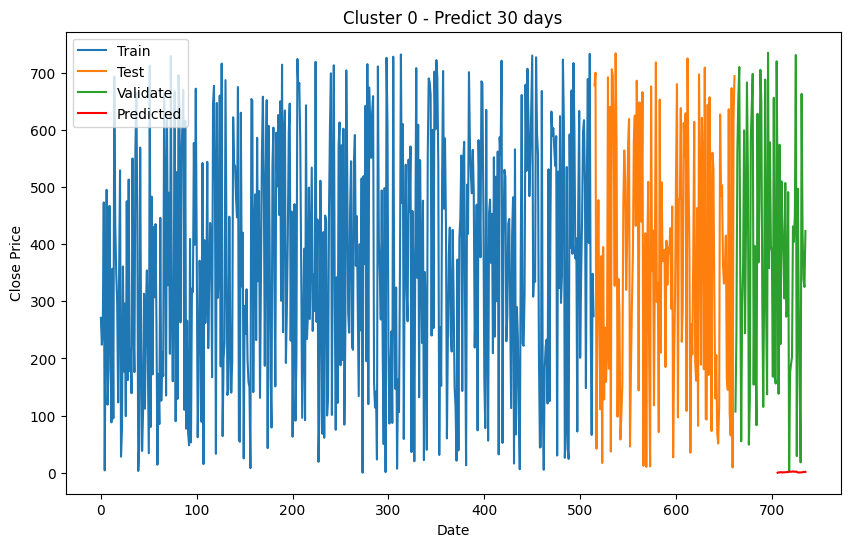

In [174]:
predicted_prices = cluster_0[-30:]
predicted_prices_reshaped = predicted_prices.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices, label='Train')
plt.plot(range(num_train, num_train+len(test_indices)), test_indices, label='Test')
plt.plot(range(num_train+num_test, num_train+num_test+len(val_indices)), val_indices, label='Validate')

plt.plot(range(len(cluster_0) - 30, len(cluster_0)), predicted_prices_reshaped[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 0 - Predict 30 days')
plt.legend()
plt.show()

### Cluster 1

In [175]:
# Number of samples in cluster_1
num_samples1 = cluster_1.shape[0]

# Create an array of random indices for the samples
indices1 = np.random.permutation(num_samples1)

# Calculate the number of samples for each set
num_train1 = int(0.7 * num_samples1)
num_test1 = int(0.2 * num_samples1)

# Split the data into train, test, validate sets
train_indices1 = indices1[:num_train1]
test_indices1 = indices1[num_train1:num_train1+num_test1]
val_indices1 = indices1[num_train1+num_test1:]

# Create sublists to store the samples and corresponding labels
X_train1 = []
y_train1= []
X_test1 = []
ytest1 = []
X_val1 = []
yval1 = []

# Create X_train1 and y_train1
for i in train_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_train1.append(sample)
    y_train1.append(label)

# Create X_test1 and ytest1
for i in test_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_test1.append(sample)
    ytest1.append(label)

# Create X_val1 and yval1
for i in val_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_val1.append(sample)
    yval1.append(label)

# Convert lists to numpy arrays
X_train1 = np.array(X_train1)
y_train1= np.array(y_train1).reshape(-1)
X_test1 = np.array(X_test1)
ytest1 = np.array(ytest1).reshape(-1)
X_val1 = np.array(X_val1)
yval1 = np.array(yval1).reshape(-1)

# Check the shape of the datasets
print("X_train1 shape:", X_train1.shape)
print("y_train1shape:", y_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("ytest1 shape:", ytest1.shape)
print("X_val1 shape:", X_val1.shape)
print("yval1 shape:", yval1.shape)

X_train1 shape: (366, 100, 1)
y_train1shape: (366,)
X_test1 shape: (104, 100, 1)
ytest1 shape: (104,)
X_val1 shape: (53, 100, 1)
yval1 shape: (53,)


In [176]:
model1=Sequential()
model1.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model1.add(LSTM(50,return_sequences=True))
model1.add(LSTM(50))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [177]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
6/6 [==============================] - 9s 439ms/step - loss: 3.1296 - val_loss: 3.1747
Epoch 2/100
6/6 [==============================] - 1s 214ms/step - loss: 2.1420 - val_loss: 2.7557
Epoch 3/100
6/6 [==============================] - 1s 206ms/step - loss: 1.7364 - val_loss: 2.6105
Epoch 4/100
6/6 [==============================] - 1s 206ms/step - loss: 1.5041 - val_loss: 2.1908
Epoch 5/100
6/6 [==============================] - 1s 204ms/step - loss: 1.2117 - val_loss: 1.9102
Epoch 6/100
6/6 [==============================] - 1s 202ms/step - loss: 0.9751 - val_loss: 1.6180
Epoch 7/100
6/6 [==============================] - 1s 207ms/step - loss: 0.8135 - val_loss: 1.3820
Epoch 8/100
6/6 [==============================] - 2s 336ms/step - loss: 0.7078 - val_loss: 1.2212
Epoch 9/100
6/6 [==============================] - 2s 340ms/step - loss: 0.6094 - val_loss: 1.1038
Epoch 10/100
6/6 [==============================] - 2s 262ms/step - loss: 0.5339 - val_loss: 1.0294
Epoch 11/

In [178]:
train_predict1=model.predict(X_train1)
y_pred1=model.predict(X_test1)
y_pred_val1=model.predict(X_val1)

2/2 [==============================] - 0s 37ms/step


In [179]:
print('---------VALIDATE----------')

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAE: 1.255769036926052
RMSE: 1.7057362693010836
--------------------------
---------TEST----------
MAE: 1.291923696718184
RMSE: 1.8586589364592214
-------------------


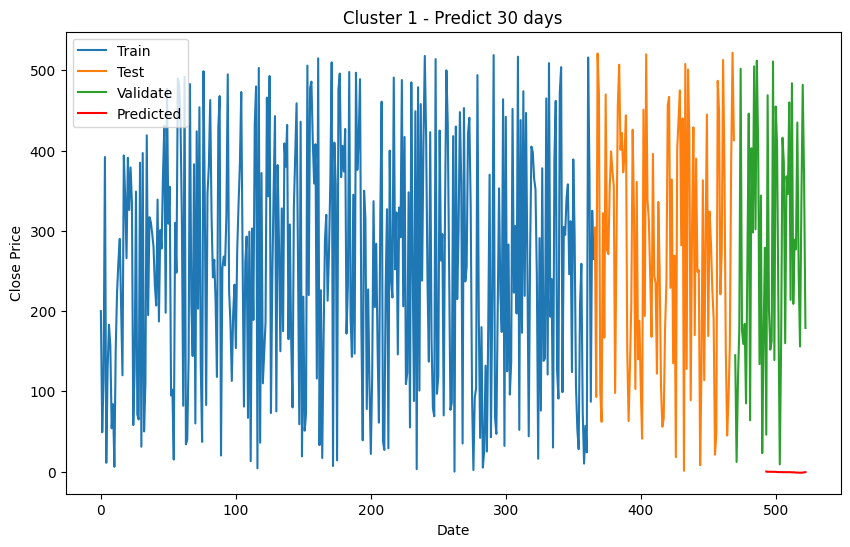

In [180]:
predicted_prices1 = cluster_1[-30:]
predicted_prices_reshaped1 = predicted_prices1.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices1, label='Train')
plt.plot(range(num_train1, num_train1+len(test_indices1)), test_indices1, label='Test')
plt.plot(range(num_train1+num_test1, num_train1+num_test1+len(val_indices1)), val_indices1, label='Validate')
plt.plot(range(len(cluster_1) - 30, len(cluster_1)), predicted_prices_reshaped1[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 1 - Predict 30 days')
plt.legend()
plt.show()

### Cluster 2

In [181]:
# Number of samples in cluster_2
num_samples2 = cluster_2.shape[0]

# Create an array of random indices for the samples
indices2 = np.random.permutation(num_samples2)

# Calculate the number of samples for each set
num_train2 = int(0.7 * num_samples2)
num_test2 = int(0.2 * num_samples2)

# Split the data into train, test, validate sets
train_indices2 = indices2[:num_train2]
test_indices2 = indices2[num_train2:num_train2+num_test2]
val_indices2 = indices2[num_train2+num_test2:]

# Create sublists to store the samples and corresponding labels
X_train2 = []
y_train2= []
X_test2 = []
ytest2 = []
X_val2 = []
yval2 = []

# Create X_train2 and y_train
for i in train_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_train2.append(sample)
    y_train2.append(label)

# Create X_test2 and ytest2
for i in test_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_test2.append(sample)
    ytest2.append(label)

# Create X_val2 and yval2
for i in val_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_val2.append(sample)
    yval2.append(label)

# Convert lists to numpy arrays
X_train2 = np.array(X_train2)
y_train2= np.array(y_train2).reshape(-1)
X_test2 = np.array(X_test2)
ytest2 = np.array(ytest2).reshape(-1)
X_val2 = np.array(X_val2)
yval2 = np.array(yval2).reshape(-1)

# Check the shape of the datasets
print("X_train2 shape:", X_train2.shape)
print("y_train2shape:", y_train2.shape)
print("X_test2 shape:", X_test2.shape)
print("ytest2 shape:", ytest2.shape)
print("X_val2 shape:", X_val2.shape)
print("yval2 shape:", yval2.shape)

X_train2 shape: (459, 100, 1)
y_train2shape: (459,)
X_test2 shape: (131, 100, 1)
ytest2 shape: (131,)
X_val2 shape: (67, 100, 1)
yval2 shape: (67,)


In [182]:
model2=Sequential()
model2.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model2.add(LSTM(50,return_sequences=True))
model2.add(LSTM(50))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',optimizer='adam')

In [183]:
model2.fit(X_train2,y_train2,validation_data=(X_test2,ytest2),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
8/8 [==============================] - 10s 370ms/step - loss: 0.7848 - val_loss: 0.3671
Epoch 2/100
8/8 [==============================] - 2s 212ms/step - loss: 0.2749 - val_loss: 0.2904
Epoch 3/100
8/8 [==============================] - 2s 202ms/step - loss: 0.2039 - val_loss: 0.2493
Epoch 4/100
8/8 [==============================] - 2s 202ms/step - loss: 0.1458 - val_loss: 0.2235
Epoch 5/100
8/8 [==============================] - 2s 201ms/step - loss: 0.1285 - val_loss: 0.2040
Epoch 6/100
8/8 [==============================] - 3s 334ms/step - loss: 0.1158 - val_loss: 0.1946
Epoch 7/100
8/8 [==============================] - 3s 320ms/step - loss: 0.1062 - val_loss: 0.1880
Epoch 8/100
8/8 [==============================] - 2s 203ms/step - loss: 0.1001 - val_loss: 0.1781
Epoch 9/100
8/8 [==============================] - 2s 206ms/step - loss: 0.0936 - val_loss: 0.1700
Epoch 10/100
8/8 [==============================] - 2s 201ms/step - loss: 0.0872 - val_loss: 0.1619
Epoch 11

In [184]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

3/3 [==============================] - 0s 42ms/step


In [185]:
print('---------VALIDATE----------')

valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAE: 0.7348657264378556
RMSE: 0.9053288678037222
--------------------------
---------TEST----------
MAE: 0.8689723165413162
RMSE: 1.077538867530462
-------------------


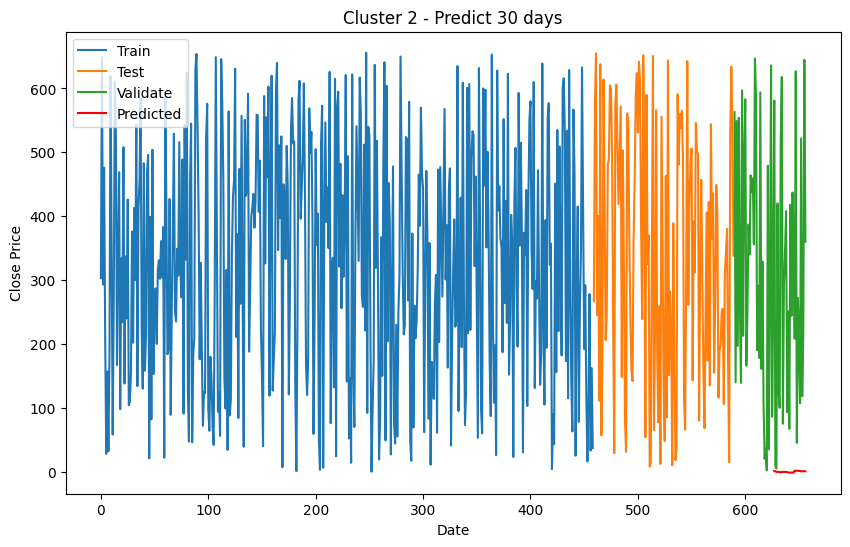

In [186]:
predicted_prices2 = cluster_2[-30:]
predicted_prices_reshaped2 = predicted_prices2.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices2, label='Train')
plt.plot(range(num_train2, num_train2+len(test_indices2)), test_indices2, label='Test')
plt.plot(range(num_train2+num_test2, num_train2+num_test2+len(val_indices2)), val_indices2, label='Validate')
plt.plot(range(len(cluster_2) - 30, len(cluster_2)), predicted_prices_reshaped2[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 2 - Predict 30 days')
plt.legend()
plt.show()

###MAE - RMSE

In [187]:
print('---------VALIDATE----------')
rnn_val_mae =  (valid_mae + valid_mae1 + valid_mae2) / 3
rnn_val_rmse = (valid_rmse + valid_rmse1 + valid_rmse2) / 3
print("Validate mae:",rnn_val_mae)
print("Validate rmse:",rnn_val_rmse)

print('---------------------------')
print('---------TEST--------------')
rnn_test_mae =  (test_mae + test_mae1 + test_mae2) / 3
rnn_test_rmse = (test_rmse + test_rmse1 + test_rmse2) / 3
print("Test mae:",rnn_test_mae)
print("Test rmse:",rnn_test_rmse)
print('---------------------------')

---------VALIDATE----------
Validate mae: 1.008677173084438
Validate rmse: 1.3414846407988863
---------------------------
---------TEST--------------
Test mae: 1.0207268749658416
Test rmse: 1.3736685073989374
---------------------------


## 5:3:2

### Cluster 0

In [188]:
# Number of samples in cluster_0
num_samples = cluster_0.shape[0]

# Create an array of random indices for the samples
indices = np.random.permutation(num_samples)

# Calculate the number of samples for each set
num_train = int(0.5 * num_samples)
num_test = int(0.3 * num_samples)

# Split the data into train, test, validate sets
train_indices = indices[:num_train]
test_indices = indices[num_train:num_train+num_test]
val_indices = indices[num_train+num_test:]

# Create sublists to store the samples and corresponding labels
X_train = []
y_train = []
X_test = []
ytest = []
X_val = []
yval = []

# Create X_train and y_train
for i in train_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_train.append(sample)
    y_train.append(label)

# Create X_test and ytest
for i in test_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_test.append(sample)
    ytest.append(label)

# Create X_val and yval
for i in val_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_val.append(sample)
    yval.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1)
X_test = np.array(X_test)
ytest = np.array(ytest).reshape(-1)
X_val = np.array(X_val)
yval = np.array(yval).reshape(-1)

# Check the shape of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("ytest shape:", ytest.shape)
print("X_val shape:", X_val.shape)
print("yval shape:", yval.shape)

X_train shape: (368, 100, 1)
y_train shape: (368,)
X_test shape: (220, 100, 1)
ytest shape: (220,)
X_val shape: (148, 100, 1)
yval shape: (148,)


In [189]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [190]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
6/6 [==============================] - 10s 631ms/step - loss: 0.8357 - val_loss: 0.5379
Epoch 2/100
6/6 [==============================] - 2s 376ms/step - loss: 0.5097 - val_loss: 0.4055
Epoch 3/100
6/6 [==============================] - 1s 233ms/step - loss: 0.3947 - val_loss: 0.3402
Epoch 4/100
6/6 [==============================] - 1s 232ms/step - loss: 0.3171 - val_loss: 0.3313
Epoch 5/100
6/6 [==============================] - 1s 226ms/step - loss: 0.2861 - val_loss: 0.2964
Epoch 6/100
6/6 [==============================] - 1s 234ms/step - loss: 0.2695 - val_loss: 0.2847
Epoch 7/100
6/6 [==============================] - 1s 240ms/step - loss: 0.2507 - val_loss: 0.2565
Epoch 8/100
6/6 [==============================] - 1s 238ms/step - loss: 0.2396 - val_loss: 0.2489
Epoch 9/100
6/6 [==============================] - 1s 236ms/step - loss: 0.2299 - val_loss: 0.2389
Epoch 10/100
6/6 [==============================] - 2s 345ms/step - loss: 0.2201 - val_loss: 0.2322
Epoch 11

In [191]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 41ms/step


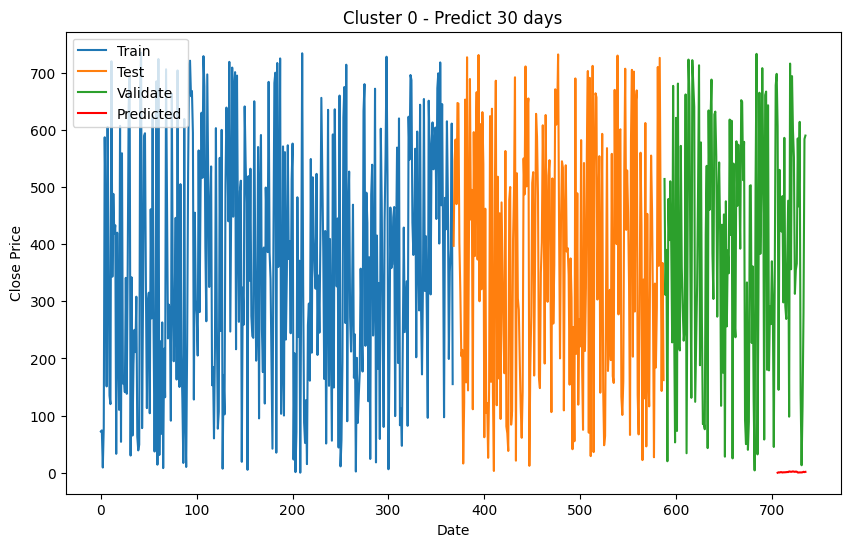

In [192]:
predicted_prices = cluster_0[-30:]
predicted_prices_reshaped = predicted_prices.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices, label='Train')
plt.plot(range(num_train, num_train+len(test_indices)), test_indices, label='Test')
plt.plot(range(num_train+num_test, num_train+num_test+len(val_indices)), val_indices, label='Validate')

plt.plot(range(len(cluster_0) - 30, len(cluster_0)), predicted_prices_reshaped[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 0 - Predict 30 days')
plt.legend()
plt.show()

In [193]:
print('---------VALIDATE----------')

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAE: 1.0028483779874577
RMSE: 1.331801832474548
--------------------------
---------TEST----------
MAE: 0.8913566828482382
RMSE: 1.1667201682764723
-------------------


### Cluster 1

In [194]:
# Number of samples in cluster_1
num_samples1 = cluster_1.shape[0]

# Create an array of random indices for the samples
indices1 = np.random.permutation(num_samples1)

# Calculate the number of samples for each set
num_train1 = int(0.5 * num_samples1)
num_test1 = int(0.3 * num_samples1)

# Split the data into train, test, validate sets
train_indices1 = indices1[:num_train1]
test_indices1 = indices1[num_train1:num_train1+num_test1]
val_indices1 = indices1[num_train1+num_test1:]

# Create sublists to store the samples and corresponding labels
X_train1 = []
y_train1= []
X_test1 = []
ytest1 = []
X_val1 = []
yval1 = []

# Create X_train1 and y_train
for i in train_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_train1.append(sample)
    y_train1.append(label)

# Create X_test1 and ytest1
for i in test_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_test1.append(sample)
    ytest1.append(label)

# Create X_val1 and yval1
for i in val_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_val1.append(sample)
    yval1.append(label)

# Convert lists to numpy arrays
X_train1 = np.array(X_train1)
y_train1= np.array(y_train1).reshape(-1)
X_test1 = np.array(X_test1)
ytest1 = np.array(ytest1).reshape(-1)
X_val1 = np.array(X_val1)
yval1 = np.array(yval1).reshape(-1)

# Check the shape of the datasets
print("X_train1 shape:", X_train1.shape)
print("y_train1shape:", y_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("ytest1 shape:", ytest1.shape)
print("X_val1 shape:", X_val1.shape)
print("yval1 shape:", yval1.shape)

X_train1 shape: (261, 100, 1)
y_train1shape: (261,)
X_test1 shape: (156, 100, 1)
ytest1 shape: (156,)
X_val1 shape: (106, 100, 1)
yval1 shape: (106,)


In [195]:
model1=Sequential()
model1.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model1.add(LSTM(50,return_sequences=True))
model1.add(LSTM(50))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [196]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
5/5 [==============================] - 9s 505ms/step - loss: 3.8473 - val_loss: 2.9195
Epoch 2/100
5/5 [==============================] - 1s 218ms/step - loss: 2.4092 - val_loss: 2.3262
Epoch 3/100
5/5 [==============================] - 1s 213ms/step - loss: 2.1235 - val_loss: 1.9994
Epoch 4/100
5/5 [==============================] - 1s 214ms/step - loss: 1.8576 - val_loss: 1.8508
Epoch 5/100
5/5 [==============================] - 1s 231ms/step - loss: 1.7209 - val_loss: 1.6520
Epoch 6/100
5/5 [==============================] - 2s 355ms/step - loss: 1.5191 - val_loss: 1.4134
Epoch 7/100
5/5 [==============================] - 2s 354ms/step - loss: 1.3200 - val_loss: 1.2147
Epoch 8/100
5/5 [==============================] - 1s 289ms/step - loss: 1.1445 - val_loss: 1.0834
Epoch 9/100
5/5 [==============================] - 1s 218ms/step - loss: 1.0208 - val_loss: 0.9210
Epoch 10/100
5/5 [==============================] - 1s 216ms/step - loss: 0.8967 - val_loss: 0.8302
Epoch 11/

In [197]:
train_predict1=model.predict(X_train1)
y_pred1=model.predict(X_test1)
y_pred_val1=model.predict(X_val1)

4/4 [==============================] - 0s 37ms/step


In [198]:
print('---------VALIDATE----------')

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAE: 1.1708424395992043
RMSE: 1.6751365874629118
--------------------------
---------TEST----------
MAE: 1.1776443634397649
RMSE: 1.6140062968510058
-------------------


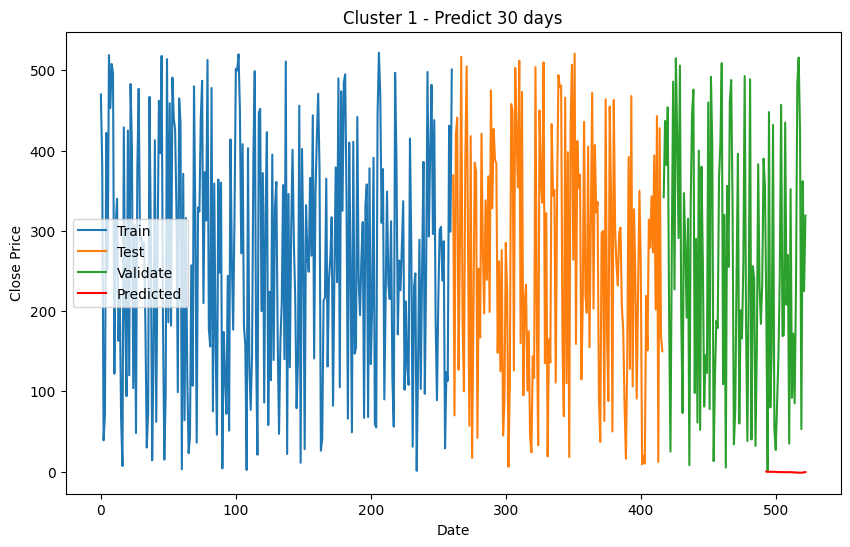

In [199]:
predicted_prices1 = cluster_1[-30:]
predicted_prices_reshaped1 = predicted_prices1.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices1, label='Train')
plt.plot(range(num_train1, num_train1+len(test_indices1)), test_indices1, label='Test')
plt.plot(range(num_train1+num_test1, num_train1+num_test1+len(val_indices1)), val_indices1, label='Validate')
plt.plot(range(len(cluster_1) - 30, len(cluster_1)), predicted_prices_reshaped1[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 1 - Predict 30 days')
plt.legend()
plt.show()

### Cluster 2

In [200]:
# Number of samples in cluster_2
num_samples2 = cluster_2.shape[0]

# Create an array of random indices for the samples
indices2 = np.random.permutation(num_samples2)

# Calculate the number of samples for each set
num_train2 = int(0.5 * num_samples2)
num_test2 = int(0.3 * num_samples2)

# Split the data into train, test, validate sets
train_indices2 = indices2[:num_train2]
test_indices2 = indices2[num_train2:num_train2+num_test2]
val_indices2 = indices2[num_train2+num_test2:]

# Create sublists to store the samples and corresponding labels
X_train2 = []
y_train2= []
X_test2 = []
ytest2 = []
X_val2 = []
yval2 = []

# Create X_train2 and y_train
for i in train_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_train2.append(sample)
    y_train2.append(label)

# Create X_test2 and ytest2
for i in test_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_test2.append(sample)
    ytest2.append(label)

# Create X_val2 and yval2
for i in val_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_val2.append(sample)
    yval2.append(label)

# Convert lists to numpy arrays
X_train2 = np.array(X_train2)
y_train2= np.array(y_train2).reshape(-1)
X_test2 = np.array(X_test2)
ytest2 = np.array(ytest2).reshape(-1)
X_val2 = np.array(X_val2)
yval2 = np.array(yval2).reshape(-1)

# Check the shape of the datasets
print("X_train2 shape:", X_train2.shape)
print("y_train2shape:", y_train2.shape)
print("X_test2 shape:", X_test2.shape)
print("ytest2 shape:", ytest2.shape)
print("X_val2 shape:", X_val2.shape)
print("yval2 shape:", yval2.shape)

X_train2 shape: (328, 100, 1)
y_train2shape: (328,)
X_test2 shape: (197, 100, 1)
ytest2 shape: (197,)
X_val2 shape: (132, 100, 1)
yval2 shape: (132,)


In [201]:
model2=Sequential()
model2.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model2.add(LSTM(50,return_sequences=True))
model2.add(LSTM(50))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',optimizer='adam')

In [202]:
model2.fit(X_train2,y_train2,validation_data=(X_test2,ytest2),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
6/6 [==============================] - 10s 648ms/step - loss: 0.8533 - val_loss: 0.2893
Epoch 2/100
6/6 [==============================] - 1s 217ms/step - loss: 0.3540 - val_loss: 0.2013
Epoch 3/100
6/6 [==============================] - 1s 228ms/step - loss: 0.2630 - val_loss: 0.1915
Epoch 4/100
6/6 [==============================] - 1s 222ms/step - loss: 0.2365 - val_loss: 0.1328
Epoch 5/100
6/6 [==============================] - 1s 219ms/step - loss: 0.1853 - val_loss: 0.1146
Epoch 6/100
6/6 [==============================] - 1s 217ms/step - loss: 0.1614 - val_loss: 0.1094
Epoch 7/100
6/6 [==============================] - 1s 226ms/step - loss: 0.1503 - val_loss: 0.1108
Epoch 8/100
6/6 [==============================] - 1s 225ms/step - loss: 0.1498 - val_loss: 0.1113
Epoch 9/100
6/6 [==============================] - 2s 382ms/step - loss: 0.1391 - val_loss: 0.0949
Epoch 10/100
6/6 [==============================] - 2s 367ms/step - loss: 0.1344 - val_loss: 0.0889
Epoch 11

In [203]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

5/5 [==============================] - 0s 37ms/step


In [204]:
print('---------VALIDATE----------')

valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAE: 0.7744532920001898
RMSE: 0.9601937119365548
--------------------------
---------TEST----------
MAE: 0.7356153394045315
RMSE: 0.9098408220868481
-------------------


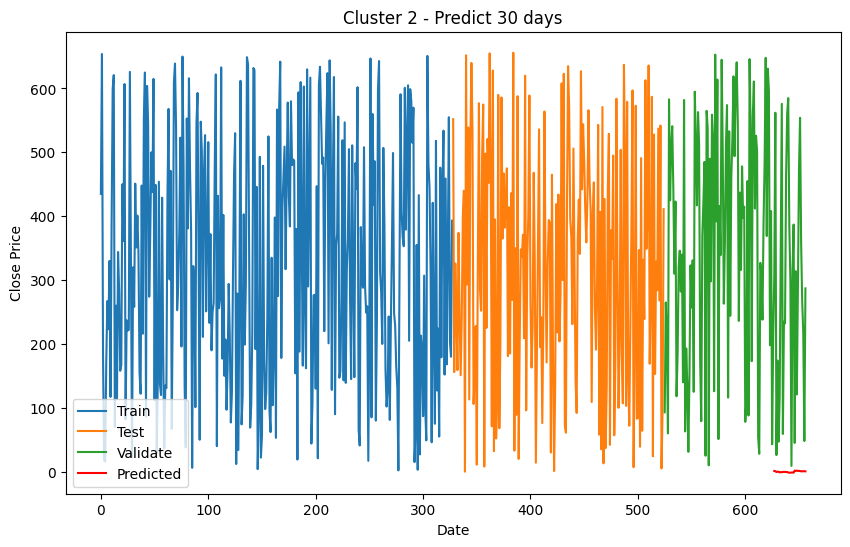

In [205]:
predicted_prices2 = cluster_2[-30:]
predicted_prices_reshaped2 = predicted_prices2.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices2, label='Train')
plt.plot(range(num_train2, num_train2+len(test_indices2)), test_indices2, label='Test')
plt.plot(range(num_train2+num_test2, num_train2+num_test2+len(val_indices2)), val_indices2, label='Validate')
plt.plot(range(len(cluster_2) - 30, len(cluster_2)), predicted_prices_reshaped2[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 2 - Predict 30 days')
plt.legend()
plt.show()

###MAE - RMSE

In [206]:
print('---------VALIDATE----------')
rnn_val_mae =  (valid_mae + valid_mae1 + valid_mae2) / 3
rnn_val_rmse = (valid_rmse + valid_rmse1 + valid_rmse2) / 3
print("Validate mae:",rnn_val_mae)
print("Validate rmse:",rnn_val_rmse)

print('---------------------------')
print('---------TEST--------------')
rnn_test_mae =  (test_mae + test_mae1 + test_mae2) / 3
rnn_test_rmse = (test_rmse + test_rmse1 + test_rmse2) / 3
print("Test mae:",rnn_test_mae)
print("Test rmse:",rnn_test_rmse)
print('---------------------------')

---------VALIDATE----------
Validate mae: 0.9827147031956173
Validate rmse: 1.3223773772913383
---------------------------
---------TEST--------------
Test mae: 0.934872128564178
Test rmse: 1.230189095738109
---------------------------


## 6:2:2

### Cluster 0

In [207]:
# Number of samples in cluster_0
num_samples = cluster_0.shape[0]

# Create an array of random indices for the samples
indices = np.random.permutation(num_samples)

# Calculate the number of samples for each set
num_train = int(0.6 * num_samples)
num_test = int(0.2 * num_samples)

# Split the data into train, test, validate sets
train_indices = indices[:num_train]
test_indices = indices[num_train:num_train+num_test]
val_indices = indices[num_train+num_test:]

# Create sublists to store the samples and corresponding labels
X_train = []
y_train = []
X_test = []
ytest = []
X_val = []
yval = []

# Create X_train and y_train
for i in train_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_train.append(sample)
    y_train.append(label)

# Create X_test and ytest
for i in test_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_test.append(sample)
    ytest.append(label)

# Create X_val and yval
for i in val_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_val.append(sample)
    yval.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1)
X_test = np.array(X_test)
ytest = np.array(ytest).reshape(-1)
X_val = np.array(X_val)
yval = np.array(yval).reshape(-1)

# Check the shape of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("ytest shape:", ytest.shape)
print("X_val shape:", X_val.shape)
print("yval shape:", yval.shape)

X_train shape: (441, 100, 1)
y_train shape: (441,)
X_test shape: (147, 100, 1)
ytest shape: (147,)
X_val shape: (148, 100, 1)
yval shape: (148,)


In [208]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [209]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 [==============================] - 10s 625ms/step - loss: 0.7939 - val_loss: 0.5926
Epoch 2/100
7/7 [==============================] - 1s 216ms/step - loss: 0.4856 - val_loss: 0.4435
Epoch 3/100
7/7 [==============================] - 1s 209ms/step - loss: 0.3454 - val_loss: 0.3953
Epoch 4/100
7/7 [==============================] - 1s 213ms/step - loss: 0.2882 - val_loss: 0.3869
Epoch 5/100
7/7 [==============================] - 1s 214ms/step - loss: 0.2628 - val_loss: 0.3459
Epoch 6/100
7/7 [==============================] - 1s 211ms/step - loss: 0.2456 - val_loss: 0.3344
Epoch 7/100
7/7 [==============================] - 2s 220ms/step - loss: 0.2361 - val_loss: 0.3207
Epoch 8/100
7/7 [==============================] - 2s 289ms/step - loss: 0.2223 - val_loss: 0.3237
Epoch 9/100
7/7 [==============================] - 2s 349ms/step - loss: 0.2157 - val_loss: 0.3018
Epoch 10/100
7/7 [==============================] - 2s 273ms/step - loss: 0.2063 - val_loss: 0.2844
Epoch 11

In [210]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 69ms/step


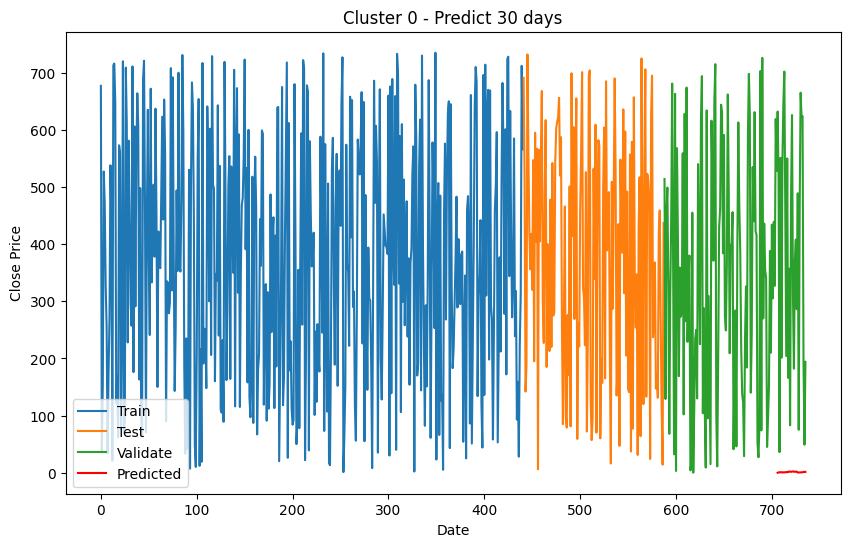

In [211]:
predicted_prices = cluster_0[-30:]
predicted_prices_reshaped = predicted_prices.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices, label='Train')
plt.plot(range(num_train, num_train+len(test_indices)), test_indices, label='Test')
plt.plot(range(num_train+num_test, num_train+num_test+len(val_indices)), val_indices, label='Validate')

plt.plot(range(len(cluster_0) - 30, len(cluster_0)), predicted_prices_reshaped[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 0 - Predict 30 days')
plt.legend()
plt.show()

In [212]:
print('---------VALIDATE----------')

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAE: 0.8694225115603097
RMSE: 1.1200259058473812
--------------------------
---------TEST----------
MAE: 0.9114142775344287
RMSE: 1.2516035925771982
-------------------


### Cluster 1

In [213]:
# Number of samples in cluster_1
num_samples1 = cluster_1.shape[0]

# Create an array of random indices for the samples
indices1 = np.random.permutation(num_samples1)

# Calculate the number of samples for each set
num_train1 = int(0.6 * num_samples1)
num_test1 = int(0.2 * num_samples1)

# Split the data into train, test, validate sets
train_indices1 = indices1[:num_train1]
test_indices1 = indices1[num_train1:num_train1+num_test1]
val_indices1 = indices1[num_train1+num_test1:]

# Create sublists to store the samples and corresponding labels
X_train1 = []
y_train1= []
X_test1 = []
ytest1 = []
X_val1 = []
yval1 = []

# Create X_train1 and y_train
for i in train_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_train1.append(sample)
    y_train1.append(label)

# Create X_test1 and ytest1
for i in test_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_test1.append(sample)
    ytest1.append(label)

# Create X_val1 and yval1
for i in val_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_val1.append(sample)
    yval1.append(label)

# Convert lists to numpy arrays
X_train1 = np.array(X_train1)
y_train1= np.array(y_train1).reshape(-1)
X_test1 = np.array(X_test1)
ytest1 = np.array(ytest1).reshape(-1)
X_val1 = np.array(X_val1)
yval1 = np.array(yval1).reshape(-1)

# Check the shape of the datasets
print("X_train1 shape:", X_train1.shape)
print("y_train1shape:", y_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("ytest1 shape:", ytest1.shape)
print("X_val1 shape:", X_val1.shape)
print("yval1 shape:", yval1.shape)

X_train1 shape: (313, 100, 1)
y_train1shape: (313,)
X_test1 shape: (104, 100, 1)
ytest1 shape: (104,)
X_val1 shape: (106, 100, 1)
yval1 shape: (106,)


In [214]:
model1=Sequential()
model1.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model1.add(LSTM(50,return_sequences=True))
model1.add(LSTM(50))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [215]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
5/5 [==============================] - 9s 875ms/step - loss: 3.7933 - val_loss: 2.3139
Epoch 2/100
5/5 [==============================] - 2s 373ms/step - loss: 2.6250 - val_loss: 1.9652
Epoch 3/100
5/5 [==============================] - 2s 363ms/step - loss: 2.2518 - val_loss: 1.6019
Epoch 4/100
5/5 [==============================] - 1s 286ms/step - loss: 2.0734 - val_loss: 1.4127
Epoch 5/100
5/5 [==============================] - 1s 223ms/step - loss: 1.8607 - val_loss: 1.1155
Epoch 6/100
5/5 [==============================] - 1s 228ms/step - loss: 1.6183 - val_loss: 0.8767
Epoch 7/100
5/5 [==============================] - 1s 220ms/step - loss: 1.3485 - val_loss: 0.6663
Epoch 8/100
5/5 [==============================] - 1s 219ms/step - loss: 1.1356 - val_loss: 0.7505
Epoch 9/100
5/5 [==============================] - 1s 214ms/step - loss: 1.0366 - val_loss: 0.6396
Epoch 10/100
5/5 [==============================] - 1s 223ms/step - loss: 0.9727 - val_loss: 0.5666
Epoch 11/

In [216]:
train_predict1=model.predict(X_train1)
y_pred1=model.predict(X_test1)
y_pred_val1=model.predict(X_val1)

4/4 [==============================] - 0s 43ms/step


In [217]:
print('---------VALIDATE----------')

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAE: 1.2710018345853857
RMSE: 1.7769559537769422
--------------------------
---------TEST----------
MAE: 1.2727504685533038
RMSE: 1.6629255806754975
-------------------


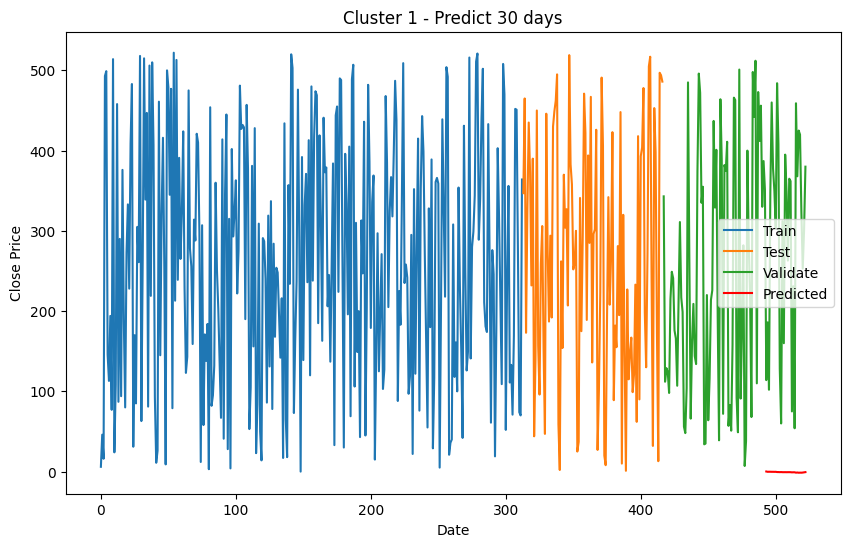

In [218]:
predicted_prices1 = cluster_1[-30:]
predicted_prices_reshaped1 = predicted_prices1.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices1, label='Train')
plt.plot(range(num_train1, num_train1+len(test_indices1)), test_indices1, label='Test')
plt.plot(range(num_train1+num_test1, num_train1+num_test1+len(val_indices1)), val_indices1, label='Validate')
plt.plot(range(len(cluster_1) - 30, len(cluster_1)), predicted_prices_reshaped1[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 1 - Predict 30 days')
plt.legend()
plt.show()

### Cluster 2

In [219]:
# Number of samples in cluster_2
num_samples2 = cluster_2.shape[0]

# Create an array of random indices for the samples
indices2 = np.random.permutation(num_samples2)

# Calculate the number of samples for each set
num_train2 = int(0.6 * num_samples2)
num_test2 = int(0.2 * num_samples2)

# Split the data into train, test, validate sets
train_indices2 = indices2[:num_train2]
test_indices2 = indices2[num_train2:num_train2+num_test2]
val_indices2 = indices2[num_train2+num_test2:]

# Create sublists to store the samples and corresponding labels
X_train2 = []
y_train2= []
X_test2 = []
ytest2 = []
X_val2 = []
yval2 = []

# Create X_train2 and y_train
for i in train_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_train2.append(sample)
    y_train2.append(label)

# Create X_test2 and ytest2
for i in test_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_test2.append(sample)
    ytest2.append(label)

# Create X_val2 and yval2
for i in val_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_val2.append(sample)
    yval2.append(label)

# Convert lists to numpy arrays
X_train2 = np.array(X_train2)
y_train2= np.array(y_train2).reshape(-1)
X_test2 = np.array(X_test2)
ytest2 = np.array(ytest2).reshape(-1)
X_val2 = np.array(X_val2)
yval2 = np.array(yval2).reshape(-1)

# Check the shape of the datasets
print("X_train2 shape:", X_train2.shape)
print("y_train2shape:", y_train2.shape)
print("X_test2 shape:", X_test2.shape)
print("ytest2 shape:", ytest2.shape)
print("X_val2 shape:", X_val2.shape)
print("yval2 shape:", yval2.shape)

X_train2 shape: (394, 100, 1)
y_train2shape: (394,)
X_test2 shape: (131, 100, 1)
ytest2 shape: (131,)
X_val2 shape: (132, 100, 1)
yval2 shape: (132,)


In [220]:
model2=Sequential()
model2.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model2.add(LSTM(50,return_sequences=True))
model2.add(LSTM(50))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',optimizer='adam')

In [221]:
model2.fit(X_train2,y_train2,validation_data=(X_test2,ytest2),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 [==============================] - 10s 411ms/step - loss: 0.6115 - val_loss: 0.2443
Epoch 2/100
7/7 [==============================] - 1s 206ms/step - loss: 0.3156 - val_loss: 0.1944
Epoch 3/100
7/7 [==============================] - 1s 210ms/step - loss: 0.2585 - val_loss: 0.2048
Epoch 4/100
7/7 [==============================] - 1s 211ms/step - loss: 0.1961 - val_loss: 0.1121
Epoch 5/100
7/7 [==============================] - 1s 207ms/step - loss: 0.1701 - val_loss: 0.1247
Epoch 6/100
7/7 [==============================] - 1s 206ms/step - loss: 0.1487 - val_loss: 0.0808
Epoch 7/100
7/7 [==============================] - 2s 322ms/step - loss: 0.1365 - val_loss: 0.0987
Epoch 8/100
7/7 [==============================] - 2s 344ms/step - loss: 0.1350 - val_loss: 0.0675
Epoch 9/100
7/7 [==============================] - 2s 217ms/step - loss: 0.1245 - val_loss: 0.0838
Epoch 10/100
7/7 [==============================] - 1s 204ms/step - loss: 0.1203 - val_loss: 0.0561
Epoch 11

In [222]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

5/5 [==============================] - 0s 58ms/step


In [223]:
print('---------VALIDATE----------')

valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAE: 0.8155584618435117
RMSE: 1.021030267182542
--------------------------
---------TEST----------
MAE: 0.7339535330335756
RMSE: 0.906761659313642
-------------------


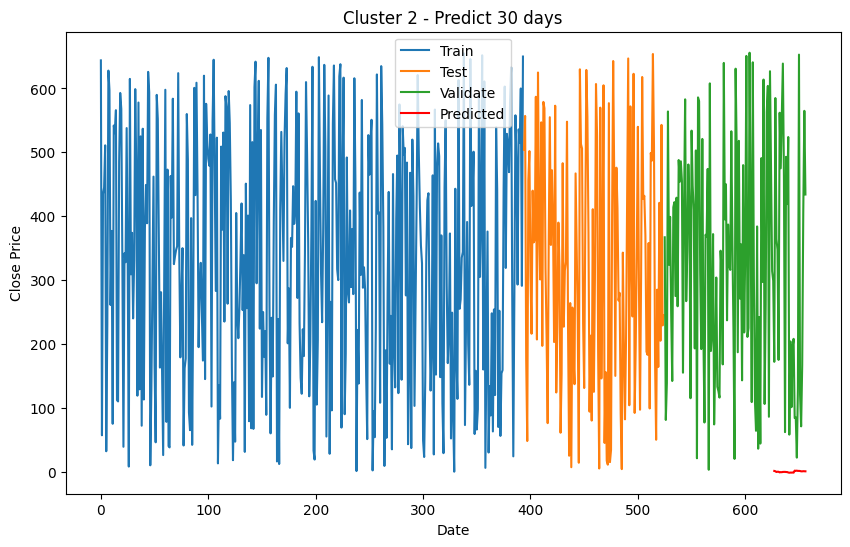

In [224]:
predicted_prices2 = cluster_2[-30:]
predicted_prices_reshaped2 = predicted_prices2.reshape((-1, 100, 1))

# Tạo biểu đồ train, test, validate và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train_indices2, label='Train')
plt.plot(range(num_train2, num_train2+len(test_indices2)), test_indices2, label='Test')
plt.plot(range(num_train2+num_test2, num_train2+num_test2+len(val_indices2)), val_indices2, label='Validate')
plt.plot(range(len(cluster_2) - 30, len(cluster_2)), predicted_prices_reshaped2[:, 0, 0], 'r', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cluster 2 - Predict 30 days')
plt.legend()
plt.show()

###MAE - RMSE

In [225]:
print('---------VALIDATE----------')
rnn_val_mae =  (valid_mae + valid_mae1 + valid_mae2) / 3
rnn_val_rmse = (valid_rmse + valid_rmse1 + valid_rmse2) / 3
print("Validate mae:",rnn_val_mae)
print("Validate rmse:",rnn_val_rmse)

print('---------------------------')
print('---------TEST--------------')
rnn_test_mae =  (test_mae + test_mae1 + test_mae2) / 3
rnn_test_rmse = (test_rmse + test_rmse1 + test_rmse2) / 3
print("Test mae:",rnn_test_mae)
print("Test rmse:",rnn_test_rmse)
print('---------------------------')

---------VALIDATE----------
Validate mae: 0.9853276026630691
Validate rmse: 1.306004042268955
---------------------------
---------TEST--------------
Test mae: 0.972706093040436
Test rmse: 1.273763610855446
---------------------------


# DNN

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

## 7:2:1

### Cluster 0

In [120]:
# Number of samples in cluster_0
num_samples = cluster_0.shape[0]

# Create an array of random indices for the samples
indices = np.random.permutation(num_samples)

# Calculate the number of samples for each set
num_train = int(0.7 * num_samples)
num_test = int(0.2 * num_samples)

# Split the data into train, test, validate sets
train_indices = indices[:num_train]
test_indices = indices[num_train:num_train+num_test]
val_indices = indices[num_train+num_test:]

# Create sublists to store the samples and corresponding labels
X_train = []
y_train = []
X_test = []
ytest = []
X_val = []
yval = []

# Create X_train and y_train
for i in train_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_train.append(sample)
    y_train.append(label)

# Create X_test and ytest
for i in test_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_test.append(sample)
    ytest.append(label)

# Create X_val and yval
for i in val_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_val.append(sample)
    yval.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1)
X_test = np.array(X_test)
ytest = np.array(ytest).reshape(-1)
X_val = np.array(X_val)
yval = np.array(yval).reshape(-1)

# Check the shape of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("ytest shape:", ytest.shape)
print("X_val shape:", X_val.shape)
print("yval shape:", yval.shape)

X_train shape: (515, 100, 1)
y_train shape: (515,)
X_test shape: (147, 100, 1)
ytest shape: (147,)
X_val shape: (74, 100, 1)
yval shape: (74,)


In [121]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(time_step,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [122]:
model.fit(X_train, y_train, epochs=100, batch_size=64)

loss = model.evaluate(X_test, ytest)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
9/9 [==============================] - 1s 3ms/step - loss: 0.7264
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 0.3254
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2479
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1846
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1448
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1185
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0996
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0838
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0583
Epoch 11/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0564
Epoch 12/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0524
Epoch 13/100
9/9 [==============================] - 0s 3ms/st

In [123]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

3/3 [==============================] - 0s 4ms/step


In [124]:
print('---------VALIDATE----------')

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAE: 0.8034367378250807
RMSE: 1.118115101107475
--------------------------
---------TEST----------
MAE: 0.8118661962843337
RMSE: 1.0545953127538152
-------------------


### Cluster 1

In [125]:
# Number of samples in cluster_1
num_samples1 = cluster_1.shape[0]

# Create an array of random indices for the samples
indices1 = np.random.permutation(num_samples1)

# Calculate the number of samples for each set
num_train1 = int(0.7 * num_samples1)
num_test1 = int(0.2 * num_samples1)

# Split the data into train, test, validate sets
train_indices1 = indices1[:num_train1]
test_indices1 = indices1[num_train1:num_train1+num_test1]
val_indices1 = indices1[num_train1+num_test1:]

# Create sublists to store the samples and corresponding labels
X_train1 = []
y_train1= []
X_test1 = []
ytest1 = []
X_val1 = []
yval1 = []

# Create X_train1 and y_train1
for i in train_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_train1.append(sample)
    y_train1.append(label)

# Create X_test1 and ytest1
for i in test_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_test1.append(sample)
    ytest1.append(label)

# Create X_val1 and yval1
for i in val_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_val1.append(sample)
    yval1.append(label)

# Convert lists to numpy arrays
X_train1 = np.array(X_train1)
y_train1= np.array(y_train1).reshape(-1)
X_test1 = np.array(X_test1)
ytest1 = np.array(ytest1).reshape(-1)
X_val1 = np.array(X_val1)
yval1 = np.array(yval1).reshape(-1)

# Check the shape of the datasets
print("X_train1 shape:", X_train1.shape)
print("y_train1shape:", y_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("ytest1 shape:", ytest1.shape)
print("X_val1 shape:", X_val1.shape)
print("yval1 shape:", yval1.shape)

X_train1 shape: (366, 100, 1)
y_train1shape: (366,)
X_test1 shape: (104, 100, 1)
ytest1 shape: (104,)
X_val1 shape: (53, 100, 1)
yval1 shape: (53,)


In [126]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(time_step,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [127]:
model1.fit(X_train1, y_train1, epochs=100, batch_size=64)

loss = model1.evaluate(X_test1, ytest1)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
6/6 [==============================] - 1s 209ms/step - loss: 0.0104
Epoch 2/100
6/6 [==============================] - 1s 201ms/step - loss: 0.0107
Epoch 3/100
6/6 [==============================] - 1s 255ms/step - loss: 0.0149
Epoch 4/100
6/6 [==============================] - 2s 333ms/step - loss: 0.0232
Epoch 5/100
6/6 [==============================] - 2s 337ms/step - loss: 0.0185
Epoch 6/100
6/6 [==============================] - 1s 192ms/step - loss: 0.0193
Epoch 7/100
6/6 [==============================] - 1s 189ms/step - loss: 0.0151
Epoch 8/100
6/6 [==============================] - 1s 189ms/step - loss: 0.0134
Epoch 9/100
6/6 [==============================] - 1s 203ms/step - loss: 0.0115
Epoch 10/100
6/6 [==============================] - 1s 199ms/step - loss: 0.0090
Epoch 11/100
6/6 [==============================] - 1s 198ms/step - loss: 0.0075
Epoch 12/100
6/6 [==============================] - 1s 193ms/step - loss: 0.0073
Epoch 13/100
6/6 [===================

In [128]:
train_predict1=model.predict(X_train1)
y_pred1=model.predict(X_test1)
y_pred_val1=model.predict(X_val1)

2/2 [==============================] - 0s 4ms/step


In [129]:
print('---------VALIDATE----------')

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAE: 1.4632343918725277
RMSE: 1.811879613999117
--------------------------
---------TEST----------
MAE: 1.61021841699633
RMSE: 2.095956840876716
-------------------


### Cluster 2

In [130]:
# Number of samples in cluster_2
num_samples2 = cluster_2.shape[0]

# Create an array of random indices for the samples
indices2 = np.random.permutation(num_samples2)

# Calculate the number of samples for each set
num_train2 = int(0.7 * num_samples2)
num_test2 = int(0.2 * num_samples2)

# Split the data into train, test, validate sets
train_indices2 = indices2[:num_train2]
test_indices2 = indices2[num_train2:num_train2+num_test2]
val_indices2 = indices2[num_train2+num_test2:]

# Create sublists to store the samples and corresponding labels
X_train2 = []
y_train2= []
X_test2 = []
ytest2 = []
X_val2 = []
yval2 = []

# Create X_train2 and y_train
for i in train_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_train2.append(sample)
    y_train2.append(label)

# Create X_test2 and ytest2
for i in test_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_test2.append(sample)
    ytest2.append(label)

# Create X_val2 and yval2
for i in val_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_val2.append(sample)
    yval2.append(label)

# Convert lists to numpy arrays
X_train2 = np.array(X_train2)
y_train2= np.array(y_train2).reshape(-1)
X_test2 = np.array(X_test2)
ytest2 = np.array(ytest2).reshape(-1)
X_val2 = np.array(X_val2)
yval2 = np.array(yval2).reshape(-1)

# Check the shape of the datasets
print("X_train2 shape:", X_train2.shape)
print("y_train2shape:", y_train2.shape)
print("X_test2 shape:", X_test2.shape)
print("ytest2 shape:", ytest2.shape)
print("X_val2 shape:", X_val2.shape)
print("yval2 shape:", yval2.shape)

X_train2 shape: (459, 100, 1)
y_train2shape: (459,)
X_test2 shape: (131, 100, 1)
ytest2 shape: (131,)
X_val2 shape: (67, 100, 1)
yval2 shape: (67,)


In [131]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(time_step,1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [132]:
model2.fit(X_train2, y_train2, epochs=100, batch_size=64)

loss = model2.evaluate(X_test2, ytest2)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
8/8 [==============================] - 2s 219ms/step - loss: 0.0129
Epoch 2/100
8/8 [==============================] - 2s 306ms/step - loss: 0.0122
Epoch 3/100
8/8 [==============================] - 2s 264ms/step - loss: 0.0136
Epoch 4/100
8/8 [==============================] - 2s 189ms/step - loss: 0.0118
Epoch 5/100
8/8 [==============================] - 1s 180ms/step - loss: 0.0116
Epoch 6/100
8/8 [==============================] - 1s 178ms/step - loss: 0.0106
Epoch 7/100
8/8 [==============================] - 1s 177ms/step - loss: 0.0104
Epoch 8/100
8/8 [==============================] - 1s 182ms/step - loss: 0.0111
Epoch 9/100
8/8 [==============================] - 1s 181ms/step - loss: 0.0113
Epoch 10/100
8/8 [==============================] - 2s 251ms/step - loss: 0.0111
Epoch 11/100
8/8 [==============================] - 3s 323ms/step - loss: 0.0097
Epoch 12/100
8/8 [==============================] - 2s 231ms/step - loss: 0.0093
Epoch 13/100
8/8 [===================

In [133]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

3/3 [==============================] - 0s 34ms/step


In [134]:
print('---------VALIDATE----------')

valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAE: 0.7107388511333392
RMSE: 0.8878531845899942
--------------------------
---------TEST----------
MAE: 0.7912938314842627
RMSE: 0.984544584662167
-------------------


###MAE - RMSE

In [135]:
print('---------VALIDATE----------')
rnn_val_mae =  (valid_mae + valid_mae1 + valid_mae2) / 3
rnn_val_rmse = (valid_rmse + valid_rmse1 + valid_rmse2) / 3
print("Validate mae:",rnn_val_mae)
print("Validate rmse:",rnn_val_rmse)

print('---------------------------')
print('---------TEST--------------')
rnn_test_mae =  (test_mae + test_mae1 + test_mae2) / 3
rnn_test_rmse = (test_rmse + test_rmse1 + test_rmse2) / 3
print("Test mae:",rnn_test_mae)
print("Test rmse:",rnn_test_rmse)
print('---------------------------')

---------VALIDATE----------
Validate mae: 0.992469993610316
Validate rmse: 1.2726159665655288
---------------------------
---------TEST--------------
Test mae: 1.0711261482549754
Test rmse: 1.3783655794308993
---------------------------


## 5:3:2

### Cluster 0

In [136]:
# Number of samples in cluster_0
num_samples = cluster_0.shape[0]

# Create an array of random indices for the samples
indices = np.random.permutation(num_samples)

# Calculate the number of samples for each set
num_train = int(0.5 * num_samples)
num_test = int(0.3 * num_samples)

# Split the data into train, test, validate sets
train_indices = indices[:num_train]
test_indices = indices[num_train:num_train+num_test]
val_indices = indices[num_train+num_test:]

# Create sublists to store the samples and corresponding labels
X_train = []
y_train = []
X_test = []
ytest = []
X_val = []
yval = []

# Create X_train and y_train
for i in train_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_train.append(sample)
    y_train.append(label)

# Create X_test and ytest
for i in test_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_test.append(sample)
    ytest.append(label)

# Create X_val and yval
for i in val_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_val.append(sample)
    yval.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1)
X_test = np.array(X_test)
ytest = np.array(ytest).reshape(-1)
X_val = np.array(X_val)
yval = np.array(yval).reshape(-1)

# Check the shape of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("ytest shape:", ytest.shape)
print("X_val shape:", X_val.shape)
print("yval shape:", yval.shape)

X_train shape: (368, 100, 1)
y_train shape: (368,)
X_test shape: (220, 100, 1)
ytest shape: (220,)
X_val shape: (148, 100, 1)
yval shape: (148,)


In [137]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(time_step,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [138]:
model.fit(X_train, y_train, epochs=100, batch_size=64)

loss = model.evaluate(X_test, ytest)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
6/6 [==============================] - 1s 5ms/step - loss: 0.8910
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5370
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 0.4143
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.3281
Epoch 5/100
6/6 [==============================] - 0s 4ms/step - loss: 0.2665
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.2300
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1931
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1645
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1438
Epoch 10/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1292
Epoch 11/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1063
Epoch 12/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0920
Epoch 13/100
6/6 [==============================] - 0s 6ms/st

In [139]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

5/5 [==============================] - 0s 3ms/step


In [140]:
print('---------VALIDATE----------')

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAE: 0.9141274237905987
RMSE: 1.1764630503893572
--------------------------
---------TEST----------
MAE: 0.8662613271152143
RMSE: 1.1039098623928498
-------------------


### Cluster 1

In [141]:
# Number of samples in cluster_1
num_samples1 = cluster_1.shape[0]

# Create an array of random indices for the samples
indices1 = np.random.permutation(num_samples1)

# Calculate the number of samples for each set
num_train1 = int(0.5 * num_samples1)
num_test1 = int(0.3 * num_samples1)

# Split the data into train, test, validate sets
train_indices1 = indices1[:num_train1]
test_indices1 = indices1[num_train1:num_train1+num_test1]
val_indices1 = indices1[num_train1+num_test1:]

# Create sublists to store the samples and corresponding labels
X_train1 = []
y_train1= []
X_test1 = []
ytest1 = []
X_val1 = []
yval1 = []

# Create X_train1 and y_train
for i in train_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_train1.append(sample)
    y_train1.append(label)

# Create X_test1 and ytest1
for i in test_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_test1.append(sample)
    ytest1.append(label)

# Create X_val1 and yval1
for i in val_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_val1.append(sample)
    yval1.append(label)

# Convert lists to numpy arrays
X_train1 = np.array(X_train1)
y_train1= np.array(y_train1).reshape(-1)
X_test1 = np.array(X_test1)
ytest1 = np.array(ytest1).reshape(-1)
X_val1 = np.array(X_val1)
yval1 = np.array(yval1).reshape(-1)

# Check the shape of the datasets
print("X_train1 shape:", X_train1.shape)
print("y_train1shape:", y_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("ytest1 shape:", ytest1.shape)
print("X_val1 shape:", X_val1.shape)
print("yval1 shape:", yval1.shape)

X_train1 shape: (261, 100, 1)
y_train1shape: (261,)
X_test1 shape: (156, 100, 1)
ytest1 shape: (156,)
X_val1 shape: (106, 100, 1)
yval1 shape: (106,)


In [142]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(time_step,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [143]:
model1.fit(X_train1, y_train1, epochs=100, batch_size=64)

loss = model1.evaluate(X_test1, ytest1)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
5/5 [==============================] - 1s 170ms/step - loss: 0.0025
Epoch 2/100
5/5 [==============================] - 1s 174ms/step - loss: 0.0022
Epoch 3/100
5/5 [==============================] - 1s 170ms/step - loss: 0.0035
Epoch 4/100
5/5 [==============================] - 1s 171ms/step - loss: 0.0041
Epoch 5/100
5/5 [==============================] - 1s 173ms/step - loss: 0.0050
Epoch 6/100
5/5 [==============================] - 1s 169ms/step - loss: 0.0028
Epoch 7/100
5/5 [==============================] - 1s 166ms/step - loss: 0.0038
Epoch 8/100
5/5 [==============================] - 1s 170ms/step - loss: 0.0028
Epoch 9/100
5/5 [==============================] - 1s 168ms/step - loss: 0.0025
Epoch 10/100
5/5 [==============================] - 1s 280ms/step - loss: 0.0018
Epoch 11/100
5/5 [==============================] - 2s 300ms/step - loss: 0.0015
Epoch 12/100
5/5 [==============================] - 2s 288ms/step - loss: 0.0018
Epoch 13/100
5/5 [===================

In [144]:
train_predict1=model.predict(X_train1)
y_pred1=model.predict(X_test1)
y_pred_val1=model.predict(X_val1)

4/4 [==============================] - 0s 3ms/step


In [145]:
print('---------VALIDATE----------')

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAE: 1.2821430549490036
RMSE: 1.7642819074833969
--------------------------
---------TEST----------
MAE: 1.3936547332888858
RMSE: 1.8912217838582177
-------------------


### Cluster 2

In [146]:
# Number of samples in cluster_2
num_samples2 = cluster_2.shape[0]

# Create an array of random indices for the samples
indices2 = np.random.permutation(num_samples2)

# Calculate the number of samples for each set
num_train2 = int(0.5 * num_samples2)
num_test2 = int(0.3 * num_samples2)

# Split the data into train, test, validate sets
train_indices2 = indices2[:num_train2]
test_indices2 = indices2[num_train2:num_train2+num_test2]
val_indices2 = indices2[num_train2+num_test2:]

# Create sublists to store the samples and corresponding labels
X_train2 = []
y_train2= []
X_test2 = []
ytest2 = []
X_val2 = []
yval2 = []

# Create X_train2 and y_train
for i in train_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_train2.append(sample)
    y_train2.append(label)

# Create X_test2 and ytest2
for i in test_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_test2.append(sample)
    ytest2.append(label)

# Create X_val2 and yval2
for i in val_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_val2.append(sample)
    yval2.append(label)

# Convert lists to numpy arrays
X_train2 = np.array(X_train2)
y_train2= np.array(y_train2).reshape(-1)
X_test2 = np.array(X_test2)
ytest2 = np.array(ytest2).reshape(-1)
X_val2 = np.array(X_val2)
yval2 = np.array(yval2).reshape(-1)

# Check the shape of the datasets
print("X_train2 shape:", X_train2.shape)
print("y_train2shape:", y_train2.shape)
print("X_test2 shape:", X_test2.shape)
print("ytest2 shape:", ytest2.shape)
print("X_val2 shape:", X_val2.shape)
print("yval2 shape:", yval2.shape)

X_train2 shape: (328, 100, 1)
y_train2shape: (328,)
X_test2 shape: (197, 100, 1)
ytest2 shape: (197,)
X_val2 shape: (132, 100, 1)
yval2 shape: (132,)


In [147]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(time_step,1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [148]:
model2.fit(X_train2, y_train2, epochs=100, batch_size=64)

loss = model2.evaluate(X_test2, ytest2)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
6/6 [==============================] - 1s 192ms/step - loss: 2.9421e-04
Epoch 2/100
6/6 [==============================] - 1s 184ms/step - loss: 1.6961e-04
Epoch 3/100
6/6 [==============================] - 1s 185ms/step - loss: 1.4742e-04
Epoch 4/100
6/6 [==============================] - 1s 183ms/step - loss: 4.6324e-04
Epoch 5/100
6/6 [==============================] - 1s 187ms/step - loss: 2.3085e-04
Epoch 6/100
6/6 [==============================] - 1s 224ms/step - loss: 2.4238e-04
Epoch 7/100
6/6 [==============================] - 2s 325ms/step - loss: 1.3732e-04
Epoch 8/100
6/6 [==============================] - 2s 314ms/step - loss: 1.4803e-04
Epoch 9/100
6/6 [==============================] - 1s 198ms/step - loss: 1.4375e-04
Epoch 10/100
6/6 [==============================] - 1s 185ms/step - loss: 2.7272e-04
Epoch 11/100
6/6 [==============================] - 1s 182ms/step - loss: 2.7577e-04
Epoch 12/100
6/6 [==============================] - 1s 184ms/step - loss: 

In [149]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

5/5 [==============================] - 0s 37ms/step


In [150]:
print('---------VALIDATE----------')

valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAE: 0.8019278908497416
RMSE: 0.9938313655675803
--------------------------
---------TEST----------
MAE: 0.8004946922892677
RMSE: 1.0045065606212669
-------------------


###MAE - RMSE

In [151]:
print('---------VALIDATE----------')
rnn_val_mae =  (valid_mae + valid_mae1 + valid_mae2) / 3
rnn_val_rmse = (valid_rmse + valid_rmse1 + valid_rmse2) / 3
print("Validate mae:",rnn_val_mae)
print("Validate rmse:",rnn_val_rmse)

print('---------------------------')
print('---------TEST--------------')
rnn_test_mae =  (test_mae + test_mae1 + test_mae2) / 3
rnn_test_rmse = (test_rmse + test_rmse1 + test_rmse2) / 3
print("Test mae:",rnn_test_mae)
print("Test rmse:",rnn_test_rmse)
print('---------------------------')

---------VALIDATE----------
Validate mae: 0.9993994565297813
Validate rmse: 1.311525441146778
---------------------------
---------TEST--------------
Test mae: 1.020136917564456
Test rmse: 1.3332127356241115
---------------------------


## 6:2:2

### Cluster 0

In [152]:
# Number of samples in cluster_0
num_samples = cluster_0.shape[0]

# Create an array of random indices for the samples
indices = np.random.permutation(num_samples)

# Calculate the number of samples for each set
num_train = int(0.6 * num_samples)
num_test = int(0.2 * num_samples)

# Split the data into train, test, validate sets
train_indices = indices[:num_train]
test_indices = indices[num_train:num_train+num_test]
val_indices = indices[num_train+num_test:]

# Create sublists to store the samples and corresponding labels
X_train = []
y_train = []
X_test = []
ytest = []
X_val = []
yval = []

# Create X_train and y_train
for i in train_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_train.append(sample)
    y_train.append(label)

# Create X_test and ytest
for i in test_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_test.append(sample)
    ytest.append(label)

# Create X_val and yval
for i in val_indices:
    sample = cluster_0[i]
    label = cluster_0[i][-1]  # Take the last value in each data sequence
    X_val.append(sample)
    yval.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1)
X_test = np.array(X_test)
ytest = np.array(ytest).reshape(-1)
X_val = np.array(X_val)
yval = np.array(yval).reshape(-1)

# Check the shape of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("ytest shape:", ytest.shape)
print("X_val shape:", X_val.shape)
print("yval shape:", yval.shape)

X_train shape: (441, 100, 1)
y_train shape: (441,)
X_test shape: (147, 100, 1)
ytest shape: (147,)
X_val shape: (148, 100, 1)
yval shape: (148,)


In [153]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(time_step,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [154]:
model.fit(X_train, y_train, epochs=100, batch_size=64)

loss = model.evaluate(X_test, ytest)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
7/7 [==============================] - 2s 3ms/step - loss: 0.9241
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4785
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 0.3460
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 0.2728
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.2203
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1724
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1372
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1063
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0887
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0753
Epoch 11/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0652
Epoch 12/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0553
Epoch 13/100
7/7 [==============================] - 0s 3ms/st

In [155]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

5/5 [==============================] - 0s 2ms/step


In [156]:
print('---------VALIDATE----------')

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAE: 0.8421249599304456
RMSE: 1.0551951085375484
--------------------------
---------TEST----------
MAE: 0.975636003572658
RMSE: 1.3070843002764514
-------------------


### Cluster 1

In [157]:
# Number of samples in cluster_1
num_samples1 = cluster_1.shape[0]

# Create an array of random indices for the samples
indices1 = np.random.permutation(num_samples1)

# Calculate the number of samples for each set
num_train1 = int(0.6 * num_samples1)
num_test1 = int(0.2 * num_samples1)

# Split the data into train, test, validate sets
train_indices1 = indices1[:num_train1]
test_indices1 = indices1[num_train1:num_train1+num_test1]
val_indices1 = indices1[num_train1+num_test1:]

# Create sublists to store the samples and corresponding labels
X_train1 = []
y_train1= []
X_test1 = []
ytest1 = []
X_val1 = []
yval1 = []

# Create X_train1 and y_train
for i in train_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_train1.append(sample)
    y_train1.append(label)

# Create X_test1 and ytest1
for i in test_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_test1.append(sample)
    ytest1.append(label)

# Create X_val1 and yval1
for i in val_indices1:
    sample = cluster_1[i]
    label = cluster_1[i][-1]  # Take the last value in each data sequence
    X_val1.append(sample)
    yval1.append(label)

# Convert lists to numpy arrays
X_train1 = np.array(X_train1)
y_train1= np.array(y_train1).reshape(-1)
X_test1 = np.array(X_test1)
ytest1 = np.array(ytest1).reshape(-1)
X_val1 = np.array(X_val1)
yval1 = np.array(yval1).reshape(-1)

# Check the shape of the datasets
print("X_train1 shape:", X_train1.shape)
print("y_train1shape:", y_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("ytest1 shape:", ytest1.shape)
print("X_val1 shape:", X_val1.shape)
print("yval1 shape:", yval1.shape)

X_train1 shape: (313, 100, 1)
y_train1shape: (313,)
X_test1 shape: (104, 100, 1)
ytest1 shape: (104,)
X_val1 shape: (106, 100, 1)
yval1 shape: (106,)


In [158]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(time_step,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [159]:
model1.fit(X_train1, y_train1, epochs=100, batch_size=64)

loss = model1.evaluate(X_test1, ytest1)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
5/5 [==============================] - 1s 199ms/step - loss: 0.0024
Epoch 2/100
5/5 [==============================] - 1s 184ms/step - loss: 0.0018
Epoch 3/100
5/5 [==============================] - 1s 182ms/step - loss: 0.0017
Epoch 4/100
5/5 [==============================] - 1s 243ms/step - loss: 0.0014
Epoch 5/100
5/5 [==============================] - 2s 314ms/step - loss: 0.0014
Epoch 6/100
5/5 [==============================] - 2s 322ms/step - loss: 0.0011
Epoch 7/100
5/5 [==============================] - 1s 252ms/step - loss: 6.8333e-04
Epoch 8/100
5/5 [==============================] - 1s 181ms/step - loss: 7.3245e-04
Epoch 9/100
5/5 [==============================] - 1s 182ms/step - loss: 0.0011
Epoch 10/100
5/5 [==============================] - 1s 184ms/step - loss: 7.6753e-04
Epoch 11/100
5/5 [==============================] - 1s 185ms/step - loss: 5.4638e-04
Epoch 12/100
5/5 [==============================] - 1s 196ms/step - loss: 4.8183e-04
Epoch 13/100
5/5 

In [160]:
train_predict1=model.predict(X_train1)
y_pred1=model.predict(X_test1)
y_pred_val1=model.predict(X_val1)

4/4 [==============================] - 0s 3ms/step


In [161]:
print('---------VALIDATE----------')

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAE: 1.4804583003488714
RMSE: 1.8751633625290682
--------------------------
---------TEST----------
MAE: 1.5161703740661345
RMSE: 1.8594473782552445
-------------------


### Cluster 2

In [162]:
# Number of samples in cluster_2
num_samples2 = cluster_2.shape[0]

# Create an array of random indices for the samples
indices2 = np.random.permutation(num_samples2)

# Calculate the number of samples for each set
num_train2 = int(0.6 * num_samples2)
num_test2 = int(0.2 * num_samples2)

# Split the data into train, test, validate sets
train_indices2 = indices2[:num_train2]
test_indices2 = indices2[num_train2:num_train2+num_test2]
val_indices2 = indices2[num_train2+num_test2:]

# Create sublists to store the samples and corresponding labels
X_train2 = []
y_train2= []
X_test2 = []
ytest2 = []
X_val2 = []
yval2 = []

# Create X_train2 and y_train
for i in train_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_train2.append(sample)
    y_train2.append(label)

# Create X_test2 and ytest2
for i in test_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_test2.append(sample)
    ytest2.append(label)

# Create X_val2 and yval2
for i in val_indices2:
    sample = cluster_2[i]
    label = cluster_2[i][-2]  # Take the last value in each data sequence
    X_val2.append(sample)
    yval2.append(label)

# Convert lists to numpy arrays
X_train2 = np.array(X_train2)
y_train2= np.array(y_train2).reshape(-1)
X_test2 = np.array(X_test2)
ytest2 = np.array(ytest2).reshape(-1)
X_val2 = np.array(X_val2)
yval2 = np.array(yval2).reshape(-1)

# Check the shape of the datasets
print("X_train2 shape:", X_train2.shape)
print("y_train2shape:", y_train2.shape)
print("X_test2 shape:", X_test2.shape)
print("ytest2 shape:", ytest2.shape)
print("X_val2 shape:", X_val2.shape)
print("yval2 shape:", yval2.shape)

X_train2 shape: (394, 100, 1)
y_train2shape: (394,)
X_test2 shape: (131, 100, 1)
ytest2 shape: (131,)
X_val2 shape: (132, 100, 1)
yval2 shape: (132,)


In [163]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(time_step,1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [164]:
model2.fit(X_train2, y_train2, epochs=100, batch_size=64)

loss = model2.evaluate(X_test2, ytest2)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
7/7 [==============================] - 1s 194ms/step - loss: 2.2741e-04
Epoch 2/100
7/7 [==============================] - 1s 186ms/step - loss: 2.8525e-04
Epoch 3/100
7/7 [==============================] - 1s 193ms/step - loss: 2.4134e-04
Epoch 4/100
7/7 [==============================] - 2s 303ms/step - loss: 1.9335e-04
Epoch 5/100
7/7 [==============================] - 2s 329ms/step - loss: 2.8991e-04
Epoch 6/100
7/7 [==============================] - 2s 228ms/step - loss: 2.1732e-04
Epoch 7/100
7/7 [==============================] - 1s 186ms/step - loss: 1.3270e-04
Epoch 8/100
7/7 [==============================] - 1s 188ms/step - loss: 1.3786e-04
Epoch 9/100
7/7 [==============================] - 1s 204ms/step - loss: 1.3003e-04
Epoch 10/100
7/7 [==============================] - 1s 192ms/step - loss: 1.1908e-04
Epoch 11/100
7/7 [==============================] - 1s 190ms/step - loss: 1.0792e-04
Epoch 12/100
7/7 [==============================] - 1s 196ms/step - loss: 

In [165]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

5/5 [==============================] - 0s 54ms/step


In [166]:
print('---------VALIDATE----------')

valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAE: 0.7980942213578119
RMSE: 0.9893052497909324
--------------------------
---------TEST----------
MAE: 0.789091612443666
RMSE: 0.9986668974334688
-------------------


###MAE - RMSE

In [167]:
print('---------VALIDATE----------')
rnn_val_mae =  (valid_mae + valid_mae1 + valid_mae2) / 3
rnn_val_rmse = (valid_rmse + valid_rmse1 + valid_rmse2) / 3
print("Validate mae:",rnn_val_mae)
print("Validate rmse:",rnn_val_rmse)

print('---------------------------')
print('---------TEST--------------')
rnn_test_mae =  (test_mae + test_mae1 + test_mae2) / 3
rnn_test_rmse = (test_rmse + test_rmse1 + test_rmse2) / 3
print("Test mae:",rnn_test_mae)
print("Test rmse:",rnn_test_rmse)
print('---------------------------')

---------VALIDATE----------
Validate mae: 1.0402258272123763
Validate rmse: 1.306554573619183
---------------------------
---------TEST--------------
Test mae: 1.0936326633608195
Test rmse: 1.3883995253217216
---------------------------
